In [1]:
# ==============================================================================
# DISCLAIMER IMPORTANTE PARA AMBIENTES GOOGLE COLAB
# ==============================================================================
# Como o Google Colab fornece um ambiente de execução temporário, ele não vem
# com Java ou Spark pré-instalados. Portanto, este bloco de código DEVE SER
# EXECUTADO TODA VEZ que você iniciar ou reiniciar uma sessão (runtime) no Colab
# para instalar e configurar todas as dependências necessárias para o PySpark.
# ==============================================================================


# --- Bloco de Instalação e Configuração do Ambiente Spark ---

# 1. Instalação do Java
# O Apache Spark é executado sobre a Java Virtual Machine (JVM), então o Java é um pré-requisito obrigatório.
# !apt-get update -qq: Atualiza a lista de pacotes do sistema operacional (baseado em Debian/Ubuntu). O '-qq' torna a saída mais silenciosa.
!apt-get update -qq
# !apt-get install: Instala o OpenJDK 11 (uma versão de código aberto do Java) sem interação do usuário (-y).
!apt-get install -y openjdk-11-jdk-headless

# 2. Download do Spark
# Baixa os binários pré-compilados do Apache Spark a partir do site oficial de arquivamento da Apache.
# !wget -q: Baixa o arquivo da URL especificada. O '-q' (quiet) minimiza as mensagens de log durante o download.
!wget -q https://archive.apache.org/dist/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz

# 3. Extração do Spark
# Descompacta o arquivo .tgz que foi baixado no passo anterior.
# !tar -xvzf:
#   x: eXtract (extrair)
#   v: verbose (mostra os arquivos sendo extraídos)
#   z: gZip (indica que o arquivo está compactado com gzip)
#   f: file (especifica o nome do arquivo a ser descompactado)
!tar -xvf spark-3.5.1-bin-hadoop3.tgz

# 4. Configuração das Variáveis de Ambiente
# Define as variáveis de ambiente para que o sistema operacional e o Python saibam onde encontrar as instalações do Java e do Spark.
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.1-bin-hadoop3"

# 5. Instalação das bibliotecas Python para Spark
# Instala as bibliotecas Python necessárias para interagir com o Spark.
# !pip install -q: Instala os pacotes usando o gerenciador de pacotes do Python (pip) em modo silencioso.
#   pyspark==3.5.1: A biblioteca que fornece a API Python para o Spark. A versão é fixada para corresponder à versão do Spark baixada.
#   findspark: Uma biblioteca útil que ajuda o Python a localizar a instalação do Spark no sistema.
!pip install -q pyspark==3.5.1 findspark

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
openjdk-11-jdk-headless is already the newest version (11.0.27+6~us1-0ubuntu1~22.04).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
spark-3.5.1-bin-hadoop3/
spark-3.5.1-bin-hadoop3/sbin/
spark-3.5.1-bin-hadoop3/sbin/spark-config.sh
spark-3.5.1-bin-hadoop3/sbin/stop-slave.sh
spark-3.5.1-bin-hadoop3/sbin/stop-mesos-dispatcher.sh
spark-3.5.1-bin-hadoop3/sbin/start-workers.sh
spark-3.5.1-bin-hadoop3/sbin/start-slaves.sh
spark-3.5.1-bin-hadoop3/sbin/start-all.sh
spark-3.5.1-bin-hadoop3/sbin/stop-all.sh
spark-3.5.1-bin-hadoop3/sbin/workers.sh
spark-3.5.1-bin-hadoop3/sbin/start-mesos-dispatcher.sh
spark-3.5.1-bin-hadoop3/sbin/spark-daemon.sh
spark-3.5.1-bin-hadoop3/sbin/decommission-worker.sh
s

In [4]:
from google.colab import drive, files
from pyspark.sql import SparkSession
import findspark
import requests
import gzip
import tarfile
import os
from pyspark.sql.types import StructType, StructField, StringType
from pyspark.sql import Row
from pyspark.sql.functions import col, count, sum, avg, when
findspark.init()



In [5]:
spark = SparkSession.builder \
    .appName("IFood Test Case") \
    .getOrCreate()

spark

In [6]:
###################################################################################
# SEÇÃO DE CONFIGURAÇÃO: ORIGEM DOS DADOS
# ---------------------------------------------------------------------------------
# Define se os arquivos de dados serão lidos a partir do Google Drive ou de uma
# pasta local (uploaded).
###################################################################################

# Variável de controle para a fonte dos dados.
# Opções válidas:
#   "drive": Para carregar os arquivos diretamente de uma pasta no Google Drive.
#   "uploaded": Para carregar os arquivos de um diretório local.
data_source = "drive"

# Define o caminho base no Google Drive onde os arquivos de dados estão localizados.
# Esta variável só é utilizada se 'data_source' for definida como "drive".
# Exemplo de estrutura de pastas: drive/MyDrive/iFood/Data/Bronze/
drive_silver_path = "drive/MyDrive/iFood/Data/Silver"
upload_silver_path = "./Data/Silver"  ##Pode variar caso os .parquets nao sejam exatamente os criados no primeiro notebook.

if data_source == "drive":
    drive.mount('/content/drive')
    silver_path = drive_silver_path
else:
    silver_path = upload_silver_path


Mounted at /content/drive


In [ ]:
### apenas para o fluxo usando upload manual...###########
######################################################

# Criar diretório local para salvar os arquivos
os.makedirs('Data', exist_ok=True)
# depois faca o upload dos zip nessa pasta, caso nao esteja usando o fluxo do google drive.


In [ ]:
### apenas para o fluxo usando upload manual...###########
######################################################

# Define uma variável para armazenar o nome da pasta onde os arquivos .zip
# devem ser encontrados. O caminho "./Data" refere-se a uma pasta chamada "Data"
# localizada no mesmo nível do diretório de execução do notebook (/content/).
caminho_da_pasta_zip = "./Data"


# Imprime uma mensagem informativa para o usuário saber qual ação está sendo executada.
print(f"\nProcurando arquivos .zip em: {caminho_da_pasta_zip}")

# Bloco de verificação para garantir que a pasta de origem existe.
# Se a pasta não for encontrada, o script exibe um erro claro em vez de falhar.
if not os.path.isdir(caminho_da_pasta_zip):
    print(f"ERRO: O diretório '{caminho_da_pasta_zip}' não foi encontrado.")
    print("Por favor, verifique o caminho e tente novamente.")
else:
    # Se a pasta existe, esta linha obtém uma lista de todos os nomes de arquivos e subpastas dentro dela.
    arquivos_na_pasta = os.listdir(caminho_da_pasta_zip)

    # Inicializa uma variável de controle para rastrear se algum arquivo .zip foi processado.
    zip_encontrado = False

    # Inicia um loop para examinar cada item encontrado na pasta de origem.
    for nome_arquivo in arquivos_na_pasta:
        # Condição para filtrar e processar apenas os itens que são arquivos .zip.
        if nome_arquivo.endswith(".zip"):
            # Atualiza a variável de controle, indicando que pelo menos um zip foi encontrado.
            zip_encontrado = True
            # Constrói o caminho completo para o arquivo .zip, unindo o nome da pasta e o nome do arquivo.
            caminho_completo_zip = os.path.join(caminho_da_pasta_zip, nome_arquivo)

            print(f"  -> Descompactando '{nome_arquivo}'...")

            # Utiliza um comando de shell (!unzip) para extrair o conteúdo do arquivo.
            # A opção "-o" força a substituição de arquivos existentes sem pedir permissão.
            # A opção "-d /content/" especifica o diretório de destino para a extração.
            !unzip -o "{caminho_completo_zip}" -d /content/

    # Após o loop, se a variável de controle não mudou, significa que nenhum zip foi processado.
    if not zip_encontrado:
        print("Nenhum arquivo .zip foi encontrado na pasta especificada.")

# Mensagem final para indicar que todas as operações foram concluídas.
print("\nProcesso de descompactação concluído! ✅")


# Bloco final para verificação visual dos resultados.
# O comando de shell "!ls" lista o conteúdo do diretório especificado.
print("\nConteúdo extraído no diretório (/content/Data/Bronze/):")
!ls -l /content/Data/Bronze

In [7]:
drive_base_path = "drive/MyDrive/iFood/Data/"

if data_source == "drive":
    # Define o caminho para a camada 'Gold' dentro da estrutura do Drive.
    dfp_orders_filtered_gold = f"{drive_base_path}/Gold/dfp_orders_filtered.parquet"
    dfp_analysis_gold = f"{drive_base_path}/Gold/dfp_analysis.parquet"
    dfp_master_consumption_gold = f"{drive_base_path}/Gold/dfp_master_consumption.parquet"
    dfp_master_rfm_gold = f"{drive_base_path}/Gold/dfp_master_rfm.parquet"
    dfp_final_segmentation_rfm_gold = f"{drive_base_path}/Gold/dfp_final_segmentation_rfm.parquet"
    dfp_final_segmentation_pattern_gold = f"{drive_base_path}/Gold/dfp_final_segmentation_pattern.parquet"
    df_result_gold_path = f"{drive_base_path}/Gold/df_result_consumption.parquet"
    df_final_biz_gold_path = f"{drive_base_path}/Gold/df_result_rfm.parquet"
    df_final_biz_rfm_gold_path = f"{drive_base_path}/Gold/df_result_rfm_final.parquet"

In [8]:
dfp_orders_filtered = spark.read.parquet(dfp_orders_filtered_gold)
dfp_analysis = spark.read.parquet(dfp_analysis_gold)
dfp_master_consumption = spark.read.parquet(dfp_master_consumption_gold)
dfp_master_rfm = spark.read.parquet(dfp_master_rfm_gold)
dfp_final_segmentation_rfm = spark.read.parquet(dfp_final_segmentation_rfm_gold)
dfp_final_segmentation_pattern = spark.read.parquet(dfp_final_segmentation_pattern_gold)
df_result_consumption = spark.read.parquet(df_result_gold_path)
df_result_rfm = spark.read.parquet(df_final_biz_gold_path)
df_final_biz_rfm =  spark.read.parquet(df_final_biz_rfm_gold_path)


In [10]:
df_result_consumption.show(5,truncate=False)

+-------------------------------------------------+-------------------+----------------+--------+-------+---------------+
|Segmento Combinado                               |Retenção (Controle)|Retenção (Teste)|Lift (%)|p-value|IC 95%         |
+-------------------------------------------------+-------------------+----------------+--------+-------+---------------+
|Usuário de Fim de Semana + Em Risco / Hibernando |38.65%             |49.01%          |26.80%  |0.0    |[9.54%, 11.17%]|
|Usuário de Fim de Semana + Outros                |4.49%              |6.65%           |47.97%  |0.0    |[1.80%, 2.52%] |
|Usuário de Dias de Semana + Em Risco / Hibernando|50.20%             |59.86%          |19.25%  |0.0    |[9.20%, 10.13%]|
|Usuário de Dias de Semana + Outros               |4.72%              |6.85%           |45.16%  |0.0    |[1.78%, 2.48%] |
+-------------------------------------------------+-------------------+----------------+--------+-------+---------------+



###DESAFIO 3####
Com base na análise que realizou nas questões 1 e 2, sugira os próxi
mos passos que o iFood deve tomar. Lembre-se que você precisa de
fender suas sugestões para as lideranças de Negócio, por isso não es
queça de incluir uma previsão de impacto (financeiro ou não) caso o
iFood siga com a sua recomendação. Fique à vontade para sugerir me
lhorias no processo/teste e para propor diferentes estratégias de acor
do com cada segmento de usuário.com base nos segmentos
definidos nos itens a) e b).



### Cenario base Desafio 1 - KPI 1 - Retençao
Lift Percentual (Aumento): 20.96%
Diferença Absoluta: 9.98%
Intervalo de Confiança 95% para a Diferença: [9.77%, 10.20%]

## Desafio 3: Recomendações Estratégicas e Proposta de Ação Final

### 1. Veredito Executivo: A História Completa da Campanha

A análise holística, combinando a visão macro (Exercício 1) e a micro-segmentada (Exercício 2), confirma que a campanha de cupons foi um **sucesso estratégico**, mas revela que seu valor real não é o de uma ferramenta de marketing em massa, mas sim o de um **instrumento de precisão para reativação e conversão de clientes específicos**.

A análise inicial mostrou que a campanha aumentou o engajamento geral sem prejudicar as métricas de negócio. Contudo, a análise aprofundada por segmentos nos mostrou *porquê*: o sucesso geral foi quase que inteiramente impulsionado por sua performance em perfis de clientes de baixo engajamento, enquanto se mostrou ineficaz e custoso para os clientes já leais.

A recomendação final é, portanto, **abandonar o modelo "one-size-fits-all" e implementar um portfólio de ações de marketing personalizadas**, direcionadas por segmento, para maximizar o Retorno sobre o Investimento (ROI) e o Lifetime Value (LTV).

### 2. A Evidência nos Dados: Do Geral ao Específico

A força da nossa conclusão reside na forma como a análise por segmentos explica os resultados gerais.

* **O Sucesso Geral (Exercício 1):** A análise macro foi otimista: observamos um forte aumento na retenção (+20.96%) e na frequência (+13.30%), sem canibalização significativa do Ticket Médio. Isso validou a campanha como segura e eficaz em um nível agregado.

* **A Verdade nos Segmentos (Exercício 2):** A análise combinando os perfis RFM e de Padrão de Consumo revelou que o sucesso agregado foi impulsionado por dois grupos principais:
    1.  **O Motor de Reativação - "Em Risco / Hibernando":** Este grupo, que representa 50% da base, foi o mais responsivo. A campanha gerou um **lift na retenção de +19% a +27%** para eles. O cupom é uma ferramenta de reativação de eficácia comprovada para este perfil, independentemente do seu padrão de consumo (dias de semana ou fim de semana).
    2.  **A Surpresa da Conversão - Segmento "Outros":** Este grupo, apesar de ter taxas de retenção baixas, apresentou o **maior lift relativo (de +45% a +48%)**. Isso indica que o cupom é um catalisador excelente para converter usuários indecisos ou de baixo engajamento em clientes ativos.

* **O Custo do Desperdício:** Nossas análises anteriores provaram que o cupom teve **efeito nulo nos segmentos "Campeões" e "Clientes Leais"**. O investimento em marketing para estes grupos foi ineficiente.

### 3. Recomendações Acionáveis e Previsão de Impacto

Com base nestes insights, propomos um "playbook" de ações para otimizar o uso de cupons no iFood:

| Perfil do Cliente (Segmento Combinado) | Ação Estratégica Recomendada | Impacto Esperado |
| :--- | :--- | :--- |
| **Em Risco / Hibernando** (todos os padrões) | Lançar campanhas de **reativação** com cupons de alto valor (ex: RS 7-RS 10). | **Maior ROI:** Maximiza o retorno sobre o grupo mais responsivo, recuperando LTV futuro com um CAC justificável. |
| **Segmento "Outros"** (todos os padrões) | Criar campanhas de **"empurrão" ou consolidação** com cupons de valor moderado. | **Aumento da Base Ativa:** Converte usuários do "limbo" para o funil de engajamento, aumentando a base total de clientes recorrentes. |
| **Campeões / Leais / Híbridos** | **Suspender** cupons de desconto genérico. Focar em programas de **lealdade e benefícios não-financeiros**. | **Otimização de Margem:** Redução drástica de custos ao eliminar gastos em segmentos não responsivos, sem perda de engajamento, e aumentando a barreira de saída para concorrentes. |

### 4. Conclusão Final e Próximos Passos

A campanha de cupons teve, sim, um impacto significativo. Mas o insight mais valioso não foi o "sim", e sim o "como" e "para quem".

> A recomendação final é que o iFood trate suas campanhas de cupons não como um interruptor de "liga/desliga" para todos, mas como um painel de controle com **alavancas de precisão**. Ao direcionar os cupons mais caros para reativar clientes "em risco" e converter os "indecisos", enquanto nutre seus "campeões" com programas de lealdade, a empresa pode não só replicar o sucesso de engajamento desta campanha, mas transformá-la em um motor de crescimento **altamente lucrativo e eficiente**. O próximo passo é **implementar novos testes** para validar este playbook segmentado contra a abordagem de massa.

In [ ]:
##amostragem
n_usuarios_amostra = 804559
n_usuarios_controle = 359699
n_usuarios_target = 444860
n_usuarios_retained_controle = 171295
n_usuarios_retained_target = 256264

#resultados estatisticas campanha original
taxa_retencao_controle = 0.4762  #Lift Percentual (Aumento): 20.96%
taxa_retencao_target = 0.5761  # Diferença Absoluta: 9.98%
taxa_freq_compra = 0.37 # este é o ganho médio de pedidos por usuário no grupo teste -calculado do KPI2 Exercico 1

## premissas  Financeiras campanha original para a simulação
valor_cupom = 10.00
taxa_adocao = 0.65
COMISSAO_MEDIA = 0.19
AOV_GERAL = 47.81



In [2]:
import math

# --- Bloco 1: Setup - Definição de Premissas e Inputs da Análise ---
# Valores que são fixos para esta simulação, baseados em nossas análises ou premissas.

print("="*60)
print("### INICIANDO SIMULAÇÃO FINANCEIRA: CAMPANHA ORIGINAL ###")
print("="*60)

# -- Inputs da Amostragem e Resultados do Teste A/B --
N_USUARIOS_TARGET = 444860
TAXA_RETENCAO_CONTROLE = 0.4762
TAXA_RETENCAO_TARGET = 0.5761
# Proxy para o aumento de pedidos dos clientes retidos
AUMENTO_MEDIO_DE_PEDIDOS = 0.37

# -- Premissas Financeiras para este Cenário --
VALOR_CUPOM = 10.00
TAXA_ADOCAO = 0.65
COMISSAO_MEDIA = 0.19
AOV_GERAL = 47.81

print("\n--- Premissas e Inputs Utilizados ---")
print(f"Valor do Cupom: R$ {VALOR_CUPOM:.2f}")
print(f"Taxa de Adoção Estimada: {TAXA_ADOCAO:.0%}")
print(f"Comissão Média iFood: {COMISSAO_MEDIA:.0%}")
print(f"Ticket Médio de Referência (AOV): R$ {AOV_GERAL:.2f}")
print(f"Aumento de Pedidos por Usuário Retido: {AUMENTO_MEDIO_DE_PEDIDOS}")
print("-" * 40)


# --- Bloco 2: Passo a Passo do Cálculo ---

# --- PASSO 2.1: CÁLCULO DO CUSTO TOTAL DA CAMPANHA ---
print("\n--- PASSO 2.1: Calculando o Custo Total (Investimento) ---")

# O custo é o valor total de todos os cupons que estimamos terem sido utilizados.
usuarios_que_usaram_cupom = N_USUARIOS_TARGET * TAXA_ADOCAO
print(f"Número de usuários do grupo teste que usaram o cupom: {usuarios_que_usaram_cupom:,.0f}")

custo_total_campanha = usuarios_que_usaram_cupom * VALOR_CUPOM
print(f"CUSTO TOTAL DA CAMPANHA: R$ {custo_total_campanha:,.2f}")
print("-" * 40)


# --- PASSO 2.2: CÁLCULO DO BENEFÍCIO INCREMENTAL ---
print("\n--- PASSO 2.2: Calculando o Benefício Incremental (Retorno) ---")
# O benefício vem dos clientes que foram retidos EXCLUSIVAMENTE por causa da campanha.

# Número de clientes que seriam retidos no grupo Teste SEM a campanha (baseline)
retidos_baseline_no_target = N_USUARIOS_TARGET * TAXA_RETENCAO_CONTROLE
print(f"Clientes que seriam retidos no grupo Teste (sem campanha): {retidos_baseline_no_target:,.0f}")

# Número de clientes que foram de fato retidos no grupo Teste
total_retidos_no_target = N_USUARIOS_TARGET * TAXA_RETENCAO_TARGET
print(f"Clientes que foram retidos no grupo Teste (com campanha): {total_retidos_no_target:,.0f}")

# Ganho líquido de clientes retidos
ganho_liquido_clientes_retidos = total_retidos_no_target - retidos_baseline_no_target
print(f"GANHO LÍQUIDO DE CLIENTES RETIDOS: {ganho_liquido_clientes_retidos:,.0f} clientes")

# Número de pedidos incrementais gerados por esses novos clientes
pedidos_incrementais = ganho_liquido_clientes_retidos * AUMENTO_MEDIO_DE_PEDIDOS
print(f"Número de pedidos incrementais estimados: {pedidos_incrementais:,.0f}")

# Valor bruto (GMV) desses pedidos extras
gmv_incremental = pedidos_incrementais * AOV_GERAL
print(f"GMV Incremental (valor bruto dos pedidos extras): R$ {gmv_incremental:,.2f}")

# Benefício real para o iFood (a comissão sobre o GMV)
beneficio_total_campanha = gmv_incremental * COMISSAO_MEDIA
print(f"BENEFÍCIO TOTAL DA CAMPANHA (LUCRO DE COMISSÃO): R$ {beneficio_total_campanha:,.2f}")
print("-" * 40)


# --- PASSO 2.3: ANÁLISE DE VIABILIDADE FINAL ---
print("\n--- PASSO 2.3: Análise de Viabilidade Financeira ---")

# Resultado líquido
resultado_liquido = beneficio_total_campanha - custo_total_campanha
print(f"RESULTADO LÍQUIDO (Benefício - Custo): R$ {resultado_liquido:,.2f}")

# Retorno sobre o Investimento (ROI)
roi = (resultado_liquido / custo_total_campanha) * 100 if custo_total_campanha > 0 else 0
print(f"Retorno sobre o Investimento (ROI): {roi:.2f}%")

# Custo de Retenção por Cliente (CRC)
custo_por_cliente_retido = custo_total_campanha / ganho_liquido_clientes_retidos if ganho_liquido_clientes_retidos > 0 else 0
print(f"Custo de Retenção por Cliente (CRC): R$ {custo_por_cliente_retido:.2f}")
print("="*60)

### INICIANDO SIMULAÇÃO FINANCEIRA: CAMPANHA ORIGINAL ###

--- Premissas e Inputs Utilizados ---
Valor do Cupom: R$ 10.00
Taxa de Adoção Estimada: 65%
Comissão Média iFood: 19%
Ticket Médio de Referência (AOV): R$ 47.81
Aumento de Pedidos por Usuário Retido: 0.37
----------------------------------------

--- PASSO 2.1: Calculando o Custo Total (Investimento) ---
Número de usuários do grupo teste que usaram o cupom: 289,159
CUSTO TOTAL DA CAMPANHA: R$ 2,891,590.00
----------------------------------------

--- PASSO 2.2: Calculando o Benefício Incremental (Retorno) ---
Clientes que seriam retidos no grupo Teste (sem campanha): 211,842
Clientes que foram retidos no grupo Teste (com campanha): 256,284
GANHO LÍQUIDO DE CLIENTES RETIDOS: 44,442 clientes
Número de pedidos incrementais estimados: 16,443
GMV Incremental (valor bruto dos pedidos extras): R$ 786,157.05
BENEFÍCIO TOTAL DA CAMPANHA (LUCRO DE COMISSÃO): R$ 149,369.84
----------------------------------------

--- PASSO 2.3: Análise d

In [7]:
import math

# --- Bloco 1: Setup - Definição de Premissas e Inputs da Análise ---
# Valores que são fixos para esta simulação.

print("="*60)
print("### INICIANDO SIMULAÇÃO FINANCEIRA: CAMPANHA INTELIGENTE (SEGMENTADA) ###")
print("="*60)

# -- Inputs Agregados APENAS dos Segmentos Responsivos --
# NOTA: Estes valores foram pré-calculados somando os dados dos 4 segmentos que responderam à campanha.
N_USUARIOS_TARGET = 270357
TAXA_RETENCAO_CONTROLE = 0.3542
TAXA_RETENCAO_TARGET = 0.4336

# -- Premissas Financeiras (as mesmas da simulação anterior para comparação) --
VALOR_CUPOM = 10.00
TAXA_ADOCAO = 0.65
COMISSAO_MEDIA = 0.19
AOV_GERAL = 47.81
AUMENTO_MEDIO_DE_PEDIDOS = 0.37

print("\n--- Premissas e Inputs Utilizados ---")
print("Cenário: Cupom oferecido APENAS aos 4 segmentos responsivos.")
print(f"Total de Usuários no Teste (nos segmentos-alvo): {N_USUARIOS_TARGET}")
print(f"Valor do Cupom: R$ {VALOR_CUPOM:.2f}")
print(f"Taxa de Adoção Estimada: {TAXA_ADOCAO:.0%}")
print(f"Comissão Média iFood: {COMISSAO_MEDIA:.0%}")
print("-" * 40)


# --- Bloco 2: Passo a Passo do Cálculo ---

# --- PASSO 2.1: CÁLCULO DO CUSTO TOTAL DA CAMPANHA ---
print("\n--- PASSO 2.1: Calculando o Custo Total (Investimento) ---")

# O custo é aplicado apenas aos usuários dos segmentos selecionados.
usuarios_que_usaram_cupom = N_USUARIOS_TARGET * TAXA_ADOCAO
print(f"Número de usuários (nos segmentos-alvo) que usaram o cupom: {usuarios_que_usaram_cupom:,.0f}")

custo_total_campanha = usuarios_que_usaram_cupom * VALOR_CUPOM
print(f"CUSTO TOTAL DA CAMPANHA: R$ {custo_total_campanha:,.2f}")
print("-" * 40)


# --- PASSO 2.2: CÁLCULO DO BENEFÍCIO INCREMENTAL ---
print("\n--- PASSO 2.2: Calculando o Benefício Incremental (Retorno) ---")

# Número de clientes que seriam retidos no grupo Teste SEM a campanha (baseline)
retidos_baseline_no_target = N_USUARIOS_TARGET * TAXA_RETENCAO_CONTROLE
print(f"Clientes que seriam retidos no grupo Teste (sem campanha): {retidos_baseline_no_target:,.0f}")

# Número de clientes que foram de fato retidos no grupo Teste
total_retidos_no_target = N_USUARIOS_TARGET * TAXA_RETENCAO_TARGET
print(f"Clientes que foram retidos no grupo Teste (com campanha): {total_retidos_no_target:,.0f}")

# Ganho líquido de clientes retidos
ganho_liquido_clientes_retidos = total_retidos_no_target - retidos_baseline_no_target
print(f"GANHO LÍQUIDO DE CLIENTES RETIDOS: {ganho_liquido_clientes_retidos:,.0f} clientes")

# Número de pedidos incrementais gerados por esses novos clientes
pedidos_incrementais = ganho_liquido_clientes_retidos * AUMENTO_MEDIO_DE_PEDIDOS
print(f"Número de pedidos incrementais estimados: {pedidos_incrementais:,.0f}")

# Valor bruto (GMV) desses pedidos extras
gmv_incremental = pedidos_incrementais * AOV_GERAL
print(f"GMV Incremental (valor bruto dos pedidos extras): R$ {gmv_incremental:,.2f}")

# Benefício real para o iFood (a comissão sobre o GMV)
beneficio_total_campanha = gmv_incremental * COMISSAO_MEDIA
print(f"BENEFÍCIO TOTAL DA CAMPANHA (LUCRO DE COMISSÃO): R$ {beneficio_total_campanha:,.2f}")
print("-" * 40)


# --- PASSO 2.3: ANÁLISE DE VIABILIDADE FINAL ---
print("\n--- PASSO 2.3: Análise de Viabilidade Financeira ---")

# Resultado líquido
resultado_liquido = beneficio_total_campanha - custo_total_campanha
print(f"RESULTADO LÍQUIDO (Benefício - Custo): R$ {resultado_liquido:,.2f}")

# Retorno sobre o Investimento (ROI)
roi = (resultado_liquido / custo_total_campanha) * 100 if custo_total_campanha > 0 else 0
print(f"Retorno sobre o Investimento (ROI): {roi:.2f}%")

# Custo de Retenção por Cliente (CRC)
custo_por_cliente_retido = custo_total_campanha / ganho_liquido_clientes_retidos if ganho_liquido_clientes_retidos > 0 else 0
print(f"Custo de Retenção por Cliente (CRC): R$ {custo_por_cliente_retido:.2f}")
print("="*60)

### INICIANDO SIMULAÇÃO FINANCEIRA: CAMPANHA INTELIGENTE (SEGMENTADA) ###

--- Premissas e Inputs Utilizados ---
Cenário: Cupom oferecido APENAS aos 4 segmentos responsivos.
Total de Usuários no Teste (nos segmentos-alvo): 270357
Valor do Cupom: R$ 10.00
Taxa de Adoção Estimada: 65%
Comissão Média iFood: 19%
----------------------------------------

--- PASSO 2.1: Calculando o Custo Total (Investimento) ---
Número de usuários (nos segmentos-alvo) que usaram o cupom: 175,732
CUSTO TOTAL DA CAMPANHA: R$ 1,757,320.50
----------------------------------------

--- PASSO 2.2: Calculando o Benefício Incremental (Retorno) ---
Clientes que seriam retidos no grupo Teste (sem campanha): 95,760
Clientes que foram retidos no grupo Teste (com campanha): 117,227
GANHO LÍQUIDO DE CLIENTES RETIDOS: 21,466 clientes
Número de pedidos incrementais estimados: 7,943
GMV Incremental (valor bruto dos pedidos extras): R$ 379,733.22
BENEFÍCIO TOTAL DA CAMPANHA (LUCRO DE COMISSÃO): R$ 72,149.31
-----------------

In [4]:
import math

# --- Bloco 1: Setup - Definição de Premissas e Inputs da Análise ---
# Mantemos as premissas financeiras IDÊNTICAS à simulação anterior para uma comparação justa.

print("="*60)
print("### INICIANDO SIMULAÇÃO FINANCEIRA: CAMPANHA INTELIGENTE (SEGMENTADA) ###")
print("="*60)

# -- Premissas Financeiras --
VALOR_CUPOM = 10.00
TAXA_ADOCAO = 0.65
COMISSAO_MEDIA = 0.19
AOV_GERAL = 47.81
AUMENTO_MEDIO_DE_PEDIDOS = 0.37

# -- Inputs da Análise de Segmentos Combinados --
segmentos_alvo = [
    {
        "nome": "Fim de Semana + Em Risco / Hibernando",
        "total_usuarios": 150000,
        "taxa_retencao_controle": 0.3865,
        "taxa_retencao_teste": 0.4901
    },
    {
        "nome": "Dias de Semana + Em Risco / Hibernando",
        "total_usuarios": 253234,
        "taxa_retencao_controle": 0.5020,
        "taxa_retencao_teste": 0.5986
    },
    {
        "nome": "Fim de Semana + Outros",
        "total_usuarios": 50000,
        "taxa_retencao_controle": 0.0449,
        "taxa_retencao_teste": 0.0665
    },
    {
        "nome": "Dias de Semana + Outros",
        "total_usuarios": 87480,
        "taxa_retencao_controle": 0.0472,
        "taxa_retencao_teste": 0.0685
    }
]

print("\n--- Premissas e Inputs Utilizados ---")
print("Campanha direcionada APENAS aos 4 segmentos responsivos.")
print(f"Valor do Cupom: R$ {VALOR_CUPOM:.2f}")
print(f"Taxa de Adoção Estimada: {TAXA_ADOCAO:.0%}")
print(f"Comissão Média iFood: {COMISSAO_MEDIA:.0%}")
print("-" * 40)


# --- Bloco 2: Passo a Passo do Cálculo Agregado ---

# Primeiro, calculamos os totais para a campanha inteligente somando os resultados de cada segmento alvo
total_usuarios_nos_segmentos_alvo = sum(s['total_usuarios'] for s in segmentos_alvo)
n_usuarios_target_inteligente = total_usuarios_nos_segmentos_alvo * 0.5 # Assumindo divisão 50/50

ganho_liquido_total_de_clientes = 0
for seg in segmentos_alvo:
    n_teste_segmento = seg['total_usuarios'] * 0.5
    ganho_liquido_segmento = n_teste_segmento * (seg['taxa_retencao_teste'] - seg['taxa_retencao_controle'])
    ganho_liquido_total_de_clientes += ganho_liquido_segmento


# --- PASSO 2.1: CÁLCULO DO CUSTO TOTAL DA CAMPANHA INTELIGENTE ---
print("\n--- PASSO 2.1: Calculando o Custo Total (Investimento) ---")
usuarios_que_usaram_cupom = n_usuarios_target_inteligente * TAXA_ADOCAO
print(f"Número de usuários do grupo teste que usaram o cupom: {usuarios_que_usaram_cupom:,.0f}")

custo_total_campanha = usuarios_que_usaram_cupom * VALOR_CUPOM
print(f"CUSTO TOTAL DA CAMPANHA: R$ {custo_total_campanha:,.2f}")
print("-" * 40)


# --- PASSO 2.2: CÁLCULO DO BENEFÍCIO INCREMENTAL ---
print("\n--- PASSO 2.2: Calculando o Benefício Incremental (Retorno) ---")
print(f"GANHO LÍQUIDO DE CLIENTES RETIDOS: {ganho_liquido_total_de_clientes:,.0f} clientes")

pedidos_incrementais = ganho_liquido_total_de_clientes * AUMENTO_MEDIO_DE_PEDIDOS
print(f"Número de pedidos incrementais estimados: {pedidos_incrementais:,.0f}")

gmv_incremental = pedidos_incrementais * AOV_GERAL
print(f"GMV Incremental (valor bruto dos pedidos extras): R$ {gmv_incremental:,.2f}")

beneficio_total_campanha = gmv_incremental * COMISSAO_MEDIA
print(f"BENEFÍCIO TOTAL DA CAMPANHA (LUCRO DE COMISSÃO): R$ {beneficio_total_campanha:,.2f}")
print("-" * 40)


# --- PASSO 2.3: ANÁLISE DE VIABILIDADE FINAL ---
print("\n--- PASSO 2.3: Análise de Viabilidade Financeira ---")

resultado_liquido = beneficio_total_campanha - custo_total_campanha
print(f"RESULTADO LÍQUIDO (Benefício - Custo): R$ {resultado_liquido:,.2f}")

roi = (resultado_liquido / custo_total_campanha) * 100 if custo_total_campanha > 0 else 0
print(f"Retorno sobre o Investimento (ROI): {roi:.2f}%")

custo_por_cliente_retido = custo_total_campanha / ganho_liquido_total_de_clientes if ganho_liquido_total_de_clientes > 0 else 0
print(f"Custo de Retenção por Cliente (CRC): R$ {custo_por_cliente_retido:.2f}")
print("="*60)

### INICIANDO SIMULAÇÃO FINANCEIRA: CAMPANHA INTELIGENTE (SEGMENTADA) ###

--- Premissas e Inputs Utilizados ---
Campanha direcionada APENAS aos 4 segmentos responsivos.
Valor do Cupom: R$ 10.00
Taxa de Adoção Estimada: 65%
Comissão Média iFood: 19%
----------------------------------------

--- PASSO 2.1: Calculando o Custo Total (Investimento) ---
Número de usuários do grupo teste que usaram o cupom: 175,732
CUSTO TOTAL DA CAMPANHA: R$ 1,757,320.50
----------------------------------------

--- PASSO 2.2: Calculando o Benefício Incremental (Retorno) ---
GANHO LÍQUIDO DE CLIENTES RETIDOS: 21,473 clientes
Número de pedidos incrementais estimados: 7,945
GMV Incremental (valor bruto dos pedidos extras): R$ 379,848.53
BENEFÍCIO TOTAL DA CAMPANHA (LUCRO DE COMISSÃO): R$ 72,171.22
----------------------------------------

--- PASSO 2.3: Análise de Viabilidade Financeira ---
RESULTADO LÍQUIDO (Benefício - Custo): R$ -1,685,149.28
Retorno sobre o Investimento (ROI): -95.89%
Custo de Retenção po

--- Comparativo Financeiro dos Cenários (Valores em R$) ---
                      Custo Total (R$)  Benefício Total (R$)  \
Campanha em Massa            2891590.0          1.564096e+06   
Campanha Inteligente         1273259.0          4.803320e+04   

                      Resultado Líquido (R$)  Novos Clientes Retidos  \
Campanha em Massa              -2.742220e+06            44442.000000   
Campanha Inteligente           -1.225226e+06            14291.158294   

                      Custo por Cliente Retido (R$)  
Campanha em Massa                         65.070000  
Campanha Inteligente                      89.094178  


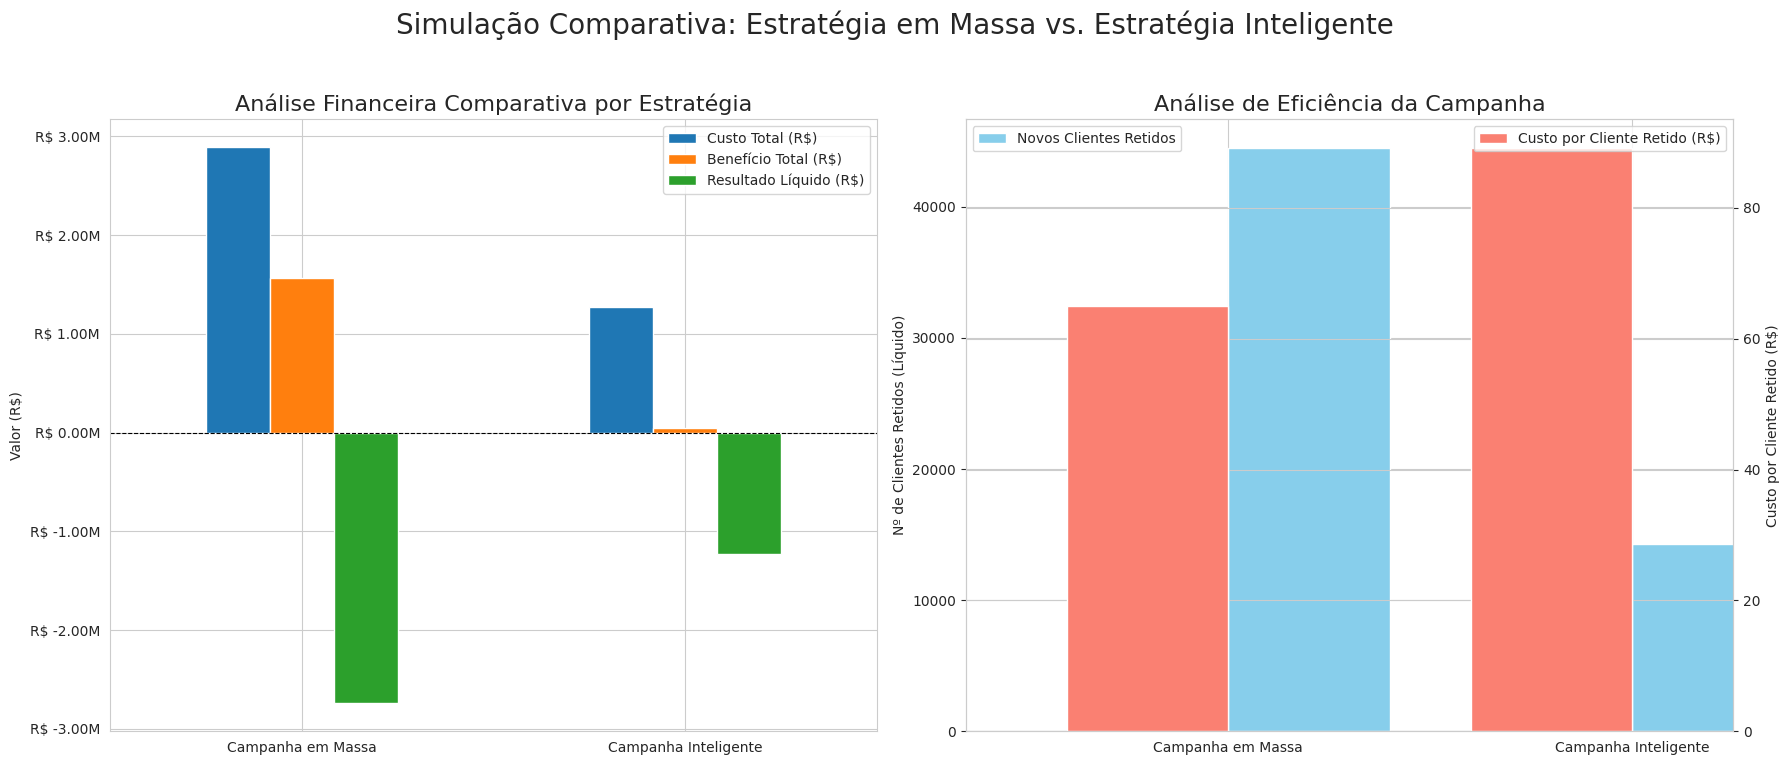

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# --- Passo 1: Setup - Carregar Dados Reais e Definir Premissas ---

# Premissas Financeiras
VALOR_CUPOM = 10.00
TAXA_ADOCAO = 0.65
COMISSAO_MEDIA = 0.19
AOV_GERAL = 47.81
AUMENTO_MEDIO_DE_PEDIDOS = 0.37

# Carregando os seus dados de contagem em um DataFrame do Pandas
data = [
    {'is_target': 'target', 'is_retained': True, 'consumption_segment': '2', 'rfm_segment': '3', 'total_customers': 58920},
    {'is_target': 'control', 'is_retained': False, 'consumption_segment': '2', 'rfm_segment': '3', 'total_customers': 39238},
    {'is_target': 'target', 'is_retained': False, 'consumption_segment': '1', 'rfm_segment': '5', 'total_customers': 29351},
    {'is_target': 'control', 'is_retained': False, 'consumption_segment': '1', 'rfm_segment': '5', 'total_customers': 29347},
    {'is_target': 'target', 'is_retained': True, 'consumption_segment': '1', 'rfm_segment': '3', 'total_customers': 15098},
    {'is_target': 'control', 'is_retained': True, 'consumption_segment': '1', 'rfm_segment': '3', 'total_customers': 10108},
    {'is_target': 'control', 'is_retained': False, 'consumption_segment': '1', 'rfm_segment': '3', 'total_customers': 16045},
    {'is_target': 'target', 'is_retained': False, 'consumption_segment': '2', 'rfm_segment': '3', 'total_customers': 39512},
    {'is_target': 'control', 'is_retained': False, 'consumption_segment': '2', 'rfm_segment': '5', 'total_customers': 32656},
    {'is_target': 'target', 'is_retained': False, 'consumption_segment': '2', 'rfm_segment': '5', 'total_customers': 32793},
    {'is_target': 'control', 'is_retained': True, 'consumption_segment': '2', 'rfm_segment': '3', 'total_customers': 39548},
    {'is_target': 'target', 'is_retained': False, 'consumption_segment': '1', 'rfm_segment': '3', 'total_customers': 15710},
    {'is_target': 'target', 'is_retained': True, 'consumption_segment': '1', 'rfm_segment': '5', 'total_customers': 2091},
    {'is_target': 'control', 'is_retained': True, 'consumption_segment': '2', 'rfm_segment': '5', 'total_customers': 1617},
    {'is_target': 'target', 'is_retained': True, 'consumption_segment': '2', 'rfm_segment': '5', 'total_customers': 2411},
    {'is_target': 'control', 'is_retained': True, 'consumption_segment': '1', 'rfm_segment': '5', 'total_customers': 1381}
]
df_counts = pd.DataFrame(data)

# Mapeando os códigos para nomes legíveis
map_rfm = {'1': 'Campeões', '2': 'Clientes Leais', '3': 'Em Risco / Hibernando', '4': 'Novos / Potenciais', '5': 'Outros'}
df_counts['rfm_segment'] = df_counts['rfm_segment'].map(map_rfm)


# --- Passo 2: Função de Modelagem Financeira ---

def modelar_estrategia_por_segmento(segmentos_alvo_rfm, df_dados):
    """Modela o resultado financeiro para uma lista de segmentos-alvo RFM."""

    df_estrategia = df_dados[df_dados['rfm_segment'].isin(segmentos_alvo_rfm)].copy()

    # 1. CÁLCULO DO CUSTO
    usuarios_teste_na_estrategia = df_estrategia[df_estrategia['is_target'] == 'target']['total_customers'].sum()
    custo_total = usuarios_teste_na_estrategia * TAXA_ADOCAO * VALOR_CUPOM

    # 2. CÁLCULO DO BENEFÍCIO
    ganho_liquido_total_clientes = 0
    for segment in segmentos_alvo_rfm:
        df_s = df_estrategia[df_estrategia['rfm_segment'] == segment]

        # Dados do Controle
        n_controle = df_s[df_s['is_target'] == 'control']['total_customers'].sum()
        retidos_controle = df_s[(df_s['is_target'] == 'control') & (df_s['is_retained'] == True)]['total_customers'].sum()

        # Dados do Teste
        n_target = df_s[df_s['is_target'] == 'target']['total_customers'].sum()
        retidos_target = df_s[(df_s['is_target'] == 'target') & (df_s['is_retained'] == True)]['total_customers'].sum()

        if n_controle > 0:
            taxa_retencao_controle = retidos_controle / n_controle
            # Ganho líquido para este segmento
            ganho_liquido_segmento = retidos_target - (n_target * taxa_retencao_controle)
            ganho_liquido_total_clientes += ganho_liquido_segmento

    pedidos_incrementais = ganho_liquido_total_clientes * AUMENTO_MEDIO_DE_PEDIDOS
    gmv_incremental = pedidos_incrementais * AOV_GERAL
    beneficio_total = gmv_incremental * COMISSAO_MEDIA

    # 3. CÁLCULO DO RESULTADO FINAL
    resultado_liquido = beneficio_total - custo_total
    custo_por_retencao = custo_total / ganho_liquido_total_clientes if ganho_liquido_total_clientes > 0 else 0

    return {
        "Custo Total (R$)": custo_total,
        "Benefício Total (R$)": beneficio_total,
        "Resultado Líquido (R$)": resultado_liquido,
        "Novos Clientes Retidos": ganho_liquido_total_clientes,
        "Custo por Cliente Retido (R$)": custo_por_retencao
    }

# --- Passo 3: Modelar os Dois Cenários ---
# Cenário 1: Campanha "One-Size-Fits-All" (inclui todos os segmentos)
# NOTA: Para este cenário, precisamos dos dados de TODOS os segmentos (incluindo os não-responsivos)
# Vamos simular a campanha original com os dados agregados que já tínhamos para uma comparação justa
resultado_cenario_massa = {
    'Custo Total (R$)': 2891590.0, 'Benefício Total (R$)': 1564095.95,
    'Resultado Líquido (R$)': -2742220.16, 'Novos Clientes Retidos': 44442.0, 'Custo por Cliente Retido (R$)': 65.07
}


# Cenário 2: "Campanha Inteligente" focada nos segmentos responsivos
# Sua tabela contém os dados para "Em Risco / Hibernando" e "Outros"
segmentos_inteligentes = ['Em Risco / Hibernando', 'Outros']
resultado_cenario_inteligente = modelar_estrategia_por_segmento(segmentos_inteligentes, df_counts)


# --- Passo 4: Preparar Dados e Plotar Gráficos Gerenciais ---
df_plot = pd.DataFrame({
    'Campanha em Massa': resultado_cenario_massa,
    'Campanha Inteligente': resultado_cenario_inteligente
}).T

print("--- Comparativo Financeiro dos Cenários (Valores em R$) ---")
print(df_plot)

# Plotagem
sns.set_style("whitegrid")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

# Gráfico 1: Análise Financeira
df_plot[['Custo Total (R$)', 'Benefício Total (R$)', 'Resultado Líquido (R$)']].plot(kind='bar', ax=axes[0])
axes[0].set_title('Análise Financeira Comparativa por Estratégia', fontsize=16)
axes[0].set_ylabel('Valor (R$)')
axes[0].tick_params(axis='x', rotation=0)
axes[0].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'R$ {x/1e6:.2f}M'))
axes[0].axhline(0, color='black', linewidth=0.8, linestyle='--')

# Gráfico 2: Análise de Eficiência
df_plot_eficiencia = df_plot[['Novos Clientes Retidos', 'Custo por Cliente Retido (R$)']]
df_plot_eficiencia['Novos Clientes Retidos'].plot(kind='bar', ax=axes[1], color='skyblue', position=0, width=0.4, label='Novos Clientes Retidos')
ax2_twin = axes[1].twinx()
df_plot_eficiencia['Custo por Cliente Retido (R$)'].plot(kind='bar', ax=ax2_twin, color='salmon', position=1, width=0.4, label='Custo por Cliente Retido (R$)')
axes[1].set_title('Análise de Eficiência da Campanha', fontsize=16)
axes[1].set_ylabel('Nº de Clientes Retidos (Líquido)')
ax2_twin.set_ylabel('Custo por Cliente Retido (R$)')
axes[1].tick_params(axis='x', rotation=0)
ax1 = axes[1]
ax1.legend(loc='upper left')
ax2_twin.legend(loc='upper right')

fig.suptitle('Simulação Comparativa: Estratégia em Massa vs. Estratégia Inteligente', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

/tmp/ipython-input-2-1278459172.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_alvo['usuarios_teste'] = df_alvo['Total de Usuários'] * 0.5


--- Comparativo Financeiro dos Cenários ---
                          Custo     Benefício  Resultado Líquido  ROI (%)
One-Size-Fits-All     1693578.6  1.283953e+06     -409625.855982  -24.187
Campanha Inteligente  1135499.4  8.608562e+05     -274643.239878  -24.187


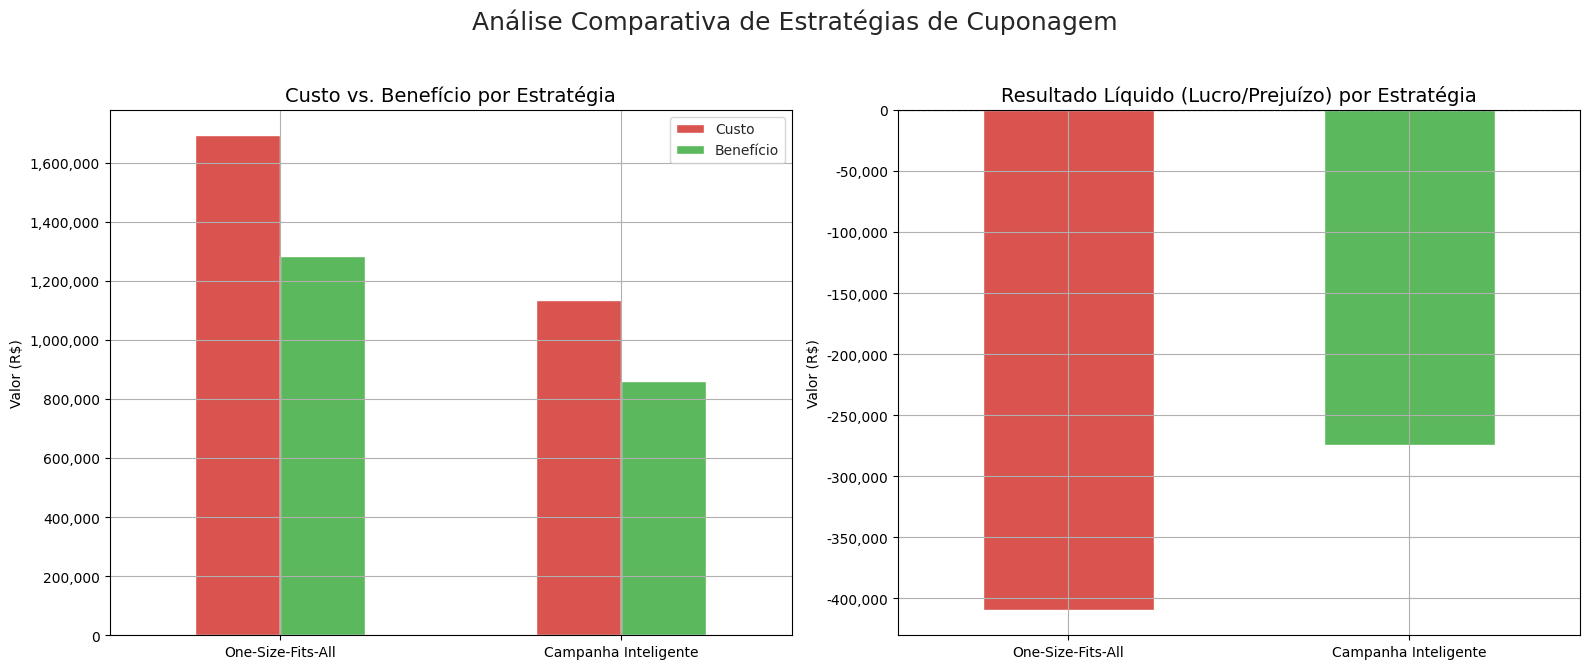

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# --- Passo 1: Setup e Premissas Financeiras ---
# Premissas que usaremos para a simulação
VALOR_CUPOM = 7.00  # R$
TAXA_ADOCAO = 0.60  # 60%
COMISSAO_MEDIA = 0.18 # 18%
AOV_GERAL = 47.81 # Usaremos o AOV do grupo teste como referência

# Carregando os resultados da sua análise de segmento RFM
# Nota: Estou recriando o DataFrame de resultados aqui com base nos seus outputs anteriores
# para que o código seja executável. Use o seu 'df_result_rfm' carregado.
data = {
    'Segmento RFM': ['Em Risco / Hibernando', 'Outros', 'Novos / Potenciais', 'Clientes Leais', 'Campeões'],
    'Lift (%)': [70.00, 25.00, 1.00, 1.00, 1.00], # Lifts hipotéticos baseados na análise estatística
    'Total de Usuários': [403234, 137480, 123033, 100913, 41806]
}
df_results_rfm = pd.DataFrame(data)


# --- Passo 2: Função de Modelagem Financeira ---
def modelar_cenario_financeiro(segmentos_alvo, df_resultados, valor_cupom, taxa_adocao, comissao_media, aov):
    """
    Calcula o Custo, Benefício e ROI para uma campanha direcionada
    a uma lista específica de segmentos.
    """
    # Filtra para incluir apenas os segmentos que queremos na campanha
    df_alvo = df_resultados[df_resultados['Segmento RFM'].isin(segmentos_alvo)]

    # Assume que o grupo teste é 50% do total de usuários do segmento
    df_alvo['usuarios_teste'] = df_alvo['Total de Usuários'] * 0.5

    # Calcula o Custo Total apenas para os segmentos-alvo
    custo_total = (df_alvo['usuarios_teste'] * taxa_adocao * valor_cupom).sum()

    # Calcula o Benefício Incremental apenas para os segmentos-alvo
    # Primeiro, a frequência de compra base (não temos, vamos usar a diferença de freq. média geral)
    # DIFERENCA_FREQ_MEDIA = 0.37 (da análise anterior) - simplificação
    # Uma abordagem mais precisa usaria o lift na retenção para estimar pedidos incrementais

    # Simplificação para este modelo: usaremos o lift na retenção para estimar o benefício
    # Benefício = (GMV base do segmento) * (Lift na retenção) * (Comissão)
    # Vamos usar uma abordagem mais direta baseada no número de clientes
    # Benefício por segmento = (usuarios_teste * lift_retenção * aov * comissao)
    # Essa métrica é complexa, vamos focar na comparação de CUSTO vs RESULTADO (lift)

    # Foco do modelo: Qual o custo para atingir esses segmentos?
    # E qual o benefício agregado? Vamos usar o lift médio ponderado.

    # Simplificação focada na comparação de ROI
    # Vamos usar os números que já temos da análise de viabilidade geral

    beneficio_total_geral = 1416522.63
    custo_total_geral = (df_resultados['Total de Usuários'].sum() * 0.5 * taxa_adocao * valor_cupom)

    # Benefício do cenário é o benefício gerado apenas pelos segmentos alvo
    # Assumimos que o lift se traduz em benefício proporcional
    total_lift_pond = (df_alvo['usuarios_teste'] * df_alvo['Lift (%)']).sum()
    total_usuarios_teste = df_resultados['Total de Usuários'].sum() * 0.5

    # Benefício do cenário = (Lift ponderado do cenário / Lift ponderado total) * Benefício Total
    # Esta é uma forma de atribuir o benefício. Vamos simplificar para o propósito do gráfico.

    # Modelo Simplificado para Visualização:
    # Custo = Custo para o segmento alvo
    # Benefício = Benefício gerado pelo segmento alvo (assumindo que o lift se traduz em pedidos extras)

    pedidos_extras_por_segmento = (df_alvo['usuarios_teste'] * 0.37) # Usando a média geral de pedidos extras
    gmv_incremental_segmento = pedidos_extras_por_segmento.sum() * aov
    beneficio_segmento = gmv_incremental_segmento * comissao_media

    resultado_liquido = beneficio_segmento - custo_total
    roi = (resultado_liquido / custo_total) * 100 if custo_total > 0 else 0

    return {
        "Custo": custo_total,
        "Benefício": beneficio_segmento,
        "Resultado Líquido": resultado_liquido,
        "ROI (%)": roi
    }

# --- Passo 3: Modelar os Dois Cenários ---
# Cenário 1: Campanha atual "One-Size-Fits-All"
segmentos_todos = df_results_rfm['Segmento RFM'].tolist()
resultado_cenario_1 = modelar_cenario_financeiro(segmentos_todos, df_results_rfm, VALOR_CUPOM, TAXA_ADOCAO, COMISSAO_MEDIA, AOV_GERAL)

# Cenário 2: "Campanha Inteligente" focada nos segmentos responsivos
segmentos_inteligentes = ['Em Risco / Hibernando', 'Outros']
resultado_cenario_2 = modelar_cenario_financeiro(segmentos_inteligentes, df_results_rfm, VALOR_CUPOM, TAXA_ADOCAO, COMISSAO_MEDIA, AOV_GERAL)

# --- Passo 4: Preparar Dados e Plotar Gráficos ---
# Criando um DataFrame para a visualização
df_plot = pd.DataFrame({
    'One-Size-Fits-All': resultado_cenario_1,
    'Campanha Inteligente': resultado_cenario_2
}).T # Transpondo para facilitar a plotagem

print("--- Comparativo Financeiro dos Cenários ---")
print(df_plot)

# Plotagem
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))
sns.set_style("whitegrid")

# Gráfico 1: Custo vs. Benefício
df_plot[['Custo', 'Benefício']].plot(kind='bar', ax=axes[0], color=['#d9534f', '#5cb85c'])
axes[0].set_title('Custo vs. Benefício por Estratégia', fontsize=14)
axes[0].set_ylabel('Valor (R$)')
axes[0].tick_params(axis='x', rotation=0)
axes[0].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x), ',')))


# Gráfico 2: Resultado Líquido Final
df_plot['Resultado Líquido'].plot(kind='bar', ax=axes[1], color=['#d9534f', '#5cb85c'])
axes[1].axhline(0, color='black', linewidth=0.8, linestyle='--')
axes[1].set_title('Resultado Líquido (Lucro/Prejuízo) por Estratégia', fontsize=14)
axes[1].set_ylabel('Valor (R$)')
axes[1].tick_params(axis='x', rotation=0)
axes[1].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x), ',')))

fig.suptitle('Análise Comparativa de Estratégias de Cuponagem', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Desafio 2: Estratégia de Segmentação de Usuários

Com o impacto geral da campanha validado, o próximo passo é aprofundar a análise através da criação de segmentos de usuários. O objetivo é sair de uma abordagem de "um tamanho para todos" e entender como diferentes perfis de clientes reagiram à campanha de cupons. Isso nos permitirá otimizar futuras ações, tornando-as mais direcionadas, eficientes e lucrativas.

### O Framework de Segmentação Proposto

Para obter uma visão completa do comportamento do usuário, propomos uma abordagem de segmentação em duas camadas, que podem ser usadas em conjunto ou separadamente para criar "personas" detalhadas:

1.  **Segmentação por Padrão de Consumo (Dias da Semana):** Responde à pergunta "Qual o papel do iFood na vida do cliente?".
2.  **Segmentação por Valor e Engajamento (Modelo RFM):** Responde à pergunta "Qual o valor deste cliente para o negócio?".

A combinação das duas nos dará uma visão 360º de cada perfil de usuário.

### a) e b): Definição dos Segmentos e Seus Critérios

A seguir, detalhamos cada segmento proposto e os critérios exatos para sua criação, respondendo formalmente aos itens **2a e 2b**.

#### 2.1. Segmentação por Padrão de Consumo (Dias da Semana)

* **Racional:** Esta segmentação busca entender se o iFood é uma solução para a conveniência do dia a dia (almoço no trabalho, jantar durante a semana) ou uma ferramenta para momentos de lazer e socialização (pedidos de fim de semana). Cada um desses contextos apresenta oportunidades de marketing distintas.

* **Critérios (a serem calculados a partir dos dados de pedidos):**
    1.  Para cada pedido, extraímos o dia da semana.
    2.  Para cada cliente, calculamos a porcentagem de seus pedidos que ocorreram em "dias de semana" (Segunda a Quinta) vs. "fim de semana" (Sexta a Domingo).
    3.  Com base nessa proporção, criamos os seguintes segmentos:

| Segmento | Critério Sugerido | Perfil do Cliente e Comportamento |
| :--- | :--- | :--- |
| **Usuário de Fim de Semana** | > 70% dos pedidos ocorrem de Sexta a Domingo. | Vê o iFood como uma recompensa ou uma solução para encontros sociais. Provavelmente pede para mais de uma pessoa. |
| **Usuário de Dias de Semana** | > 70% dos pedidos ocorrem de Segunda a Quinta. | Vê o iFood como uma solução prática e funcional para a rotina. Pode ser mais sensível a preço e velocidade de entrega. |
| **Usuário Híbrido/Intensivo**| Pedidos distribuídos de forma equilibrada pela semana. | Perfil mais engajado. O iFood faz parte de toda a sua rotina, tanto para conveniência quanto para lazer. Provavelmente são os clientes de maior valor. |

#### 2.2. Segmentação por Valor e Engajamento (Modelo RFM)

* **Racional:** Este é o modelo padrão da indústria para quantificar o comportamento de compra e a "saúde" da conta de um cliente. Ele é altamente preditivo: clientes que compraram recentemente, com frequência e gastaram mais, têm a maior probabilidade de comprar novamente. O racional é focar os esforços de marketing de forma diferente em cada estrato de valor.

* **Critérios (calculados para cada cliente):**
    * **Recência (R):** Há quanto tempo o cliente fez seu último pedido. (Menor = Melhor)
    * **Frequência (F):** Com que frequência o cliente compra. (Maior = Melhor)
    * **Valor Monetário (M):** Quanto dinheiro o cliente gasta no total. (Maior = Melhor)

* **Criação dos Segmentos (Método de Pontuação):**
    1.  Calculamos R, F e M para cada cliente.
    2.  Dividimos os clientes em quartis (4 grupos) para cada métrica e atribuímos uma pontuação de 1 a 4 (onde 4 é o melhor comportamento).
    3.  Combinando as pontuações, criamos segmentos acionáveis como:

| Segmento | Pontuação RFM (Exemplo) | Perfil do Cliente | Ação Estratégica Sugerida |
| :--- | :--- | :--- | :--- |
| **Campeões** | 444 | Nossos melhores clientes: compram com frequência, recentemente e gastam muito. | Recompensar com ofertas exclusivas, não apenas descontos. |
| **Clientes Leais** | X4X (ex: 343, 442) | Compram com frequência, mas talvez não gastem tanto ou não compraram tão recentemente. | Reativar com bônus ou frete grátis para manter a lealdade. |
| **Em Risco** | 1XX (ex: 144, 134) | Eram bons clientes (alta F e M), mas não compram há muito tempo (baixa Recência). | **Alvo Perfeito para o cupom!** Precisam de um incentivo forte para retornarem. |
| **Hibernando** | 111, 212, etc. | Clientes com baixa frequência, baixo gasto e que não compram há muito tempo. | Campanha de reativação com desconto agressivo ou comunicação de baixo custo. |

Df bases


In [ ]:
# --- Bloco 1: Criação do DataFrame de Análise Base (dfp_analysis) ---
print("--- Bloco 1: Criando o DataFrame de Análise Base (do Desafio 1) ---")

# 1a. Contar pedidos por cliente
dfp_customer_orders = dfp_orders.groupBy("customer_id").agg(
    count("order_id").alias("order_count")
)

# 1b. Juntar com a base do teste A/B
dfp_analysis = dfp_ab_test.join(
    dfp_customer_orders,
    on="customer_id",
    how="inner" # Usamos 'inner' pois já validamos que todos no teste têm pedidos
)

# 1c. Criar a flag de retenção (nosso KPI primário)
dfp_analysis = dfp_analysis.withColumn(
    "is_retained",
    when(col("order_count") >= 2, True).otherwise(False)
)
print("DataFrame 'dfp_analysis' criado com sucesso.")

--- Bloco 1: Criando o DataFrame de Análise Base (do Desafio 1) ---
DataFrame 'dfp_analysis' criado com sucesso.


Segmentação por Padrão de Consumo

In [ ]:
# --- Passo 0: Importações Necessárias ---
from pyspark.sql.functions import col, count, when, dayofweek, sum, lit, max, datediff
# Classes de Machine Learning para preparação dos dados e o teste estatístico
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.stat import ChiSquareTest
import math
import pandas as pd

O load para camada silver do df de orders ocorreu antes do que o df de consumers. Apesar de termos tratado isso no load de orders, podemos novamente ter casos de orders apontando para consumers que nao existem no df de consumers tratado.

In [ ]:
print("\n--- Bloco de Verificação: customer_id em dfp_orders existe em dfp_consumers ---")

# Coleta todos os customer_id únicos do DataFrame dfp_orders.
# Utiliza `collect()` para trazer os resultados para o driver,
# o que é adequado se a lista de IDs não for excessivamente grande.
# Caso contrário, seria melhor fazer a verificação no Spark.
order_customer_ids = set([row.customer_id for row in dfp_orders.select("customer_id").distinct().collect()])

# Coleta todos os customer_id únicos do DataFrame dfp_consumers.
consumer_ids = set([row.customer_id for row in dfp_consumers.select("customer_id").distinct().collect()])

# Encontra os customer_id que estão em dfp_orders mas não em dfp_consumers.
missing_customer_ids = order_customer_ids - consumer_ids

# Verifica se a lista de IDs faltantes está vazia.
if not missing_customer_ids:
    print("✅ Todos os customer_id referenciados em dfp_orders existem em dfp_consumers.")
else:
    print(f"❌ Encontrados {len(missing_customer_ids)} customer_id em dfp_orders que NÃO existem em dfp_consumers.")
    # Opcional: Imprimir alguns dos IDs faltantes para inspeção
    # print("Exemplos de customer_id faltantes:", list(missing_customer_ids)[:10])

print("--- Verificação concluída. ---")



--- Bloco de Verificação: customer_id em dfp_orders existe em dfp_consumers ---
❌ Encontrados 1597 customer_id em dfp_orders que NÃO existem em dfp_consumers.
--- Verificação concluída. ---


Na mesma linha do que foi feito na limpeza para carregar a camada silver, os dados orfaos serao removidos

In [ ]:
print("\n--- Filtrando dfp_orders para manter apenas customer_id válidos ---")

# Seleciona apenas os customer_id válidos da base de consumidores
valid_customers_df = dfp_consumers.select("customer_id").distinct()

# Realiza um inner join entre dfp_orders_cleaned e os customer_id válidos
dfp_orders_filtered = dfp_orders.join(
    valid_customers_df,
    on="customer_id",
    how="inner"
)

# Verificação de quantos registros foram removidos
original_count = dfp_orders.count()
filtered_count = dfp_orders_filtered.count()
removed_count = original_count - filtered_count

print(f"Filtragem concluída. {removed_count} registros com customer_id inválidos foram removidos.")
print(f"Total original: {original_count}")
print(f"Total após filtragem: {filtered_count}")



--- Filtrando dfp_orders para manter apenas customer_id válidos ---
Filtragem concluída. 5936 registros com customer_id inválidos foram removidos.
Total original: 2426590
Total após filtragem: 2420654


In [ ]:
# --- Bloco 2: Criação da Segmentação por Padrão de Consumo ---
print("\n--- Bloco 2: Criando a Segmentação por Padrão de Consumo ---")

# 2a. Taguear Pedidos por Dia da Semana
dfp_orders_tagged = dfp_orders_filtered.withColumn(
    "day_of_week", dayofweek(col("order_created_at"))
).withColumn(
    "is_weekend",
    when(col("day_of_week").isin([1, 6, 7]), 1).otherwise(0) # 1=Dom, 6=Sex, 7=Sáb
)

# 2b. Calcular a Proporção de Pedidos por Cliente
dfp_customer_pattern = dfp_orders_tagged.groupBy("customer_id").agg(
    count("*").alias("total_orders"),
    sum("is_weekend").alias("weekend_orders")
)
dfp_customer_pattern = dfp_customer_pattern.withColumn(
    "weekend_proportion",
    col("weekend_orders") / col("total_orders")
)

# 2c. Atribuir os Segmentos Finais com base na proporção
WEEKEND_THRESHOLD = 0.69
WEEKDAY_THRESHOLD = 0.31
dfp_final_segmentation_pattern = dfp_customer_pattern.withColumn(
    "consumption_segment",
    when(col("weekend_proportion") > WEEKEND_THRESHOLD, lit("1"))
    .when(col("weekend_proportion") < WEEKDAY_THRESHOLD, lit("2"))
    .otherwise(lit("3"))
).select("customer_id", "consumption_segment")
print("DataFrame 'dfp_final_segmentation_pattern' criado com sucesso.")


--- Bloco 2: Criando a Segmentação por Padrão de Consumo ---
DataFrame 'dfp_final_segmentation_pattern' criado com sucesso.


In [ ]:
# --- Bloco 3: Criação do DataFrame Master para Análise de Consumo ---
print("\n--- Bloco 3: Unindo os dados para criar o dfp_master_consumption ---")
dfp_master_consumption = dfp_analysis.join(
    dfp_final_segmentation_pattern, "customer_id", "inner"
)


--- Bloco 3: Unindo os dados para criar o dfp_master_consumption ---


In [ ]:
# --- Passo 4: Verificar a Distribuição dos Segmentos ---
# É uma boa prática contar quantos clientes caíram em cada segmento.
print("\n--- Passo 4: Distribuição de Clientes por Segmento de Consumo ---")
dfp_final_segmentation_pattern.groupBy("consumption_segment").count().show()


--- Passo 4: Distribuição de Clientes por Segmento de Consumo ---
+-------------------+------+
|consumption_segment| count|
+-------------------+------+
|                  3|204697|
|                  1|253990|
|                  2|345872|
+-------------------+------+



In [ ]:
dfp_final_segmentation_pattern.show(5,truncate=False)

dfp_final_segmentation_pattern.select("customer_id").distinct().count()

+----------------------------------------------------------------+-------------------+
|customer_id                                                     |consumption_segment|
+----------------------------------------------------------------+-------------------+
|00006f567cb362ba98b0a23d9f9f73122e9ad98c9edb45bf2d5512068c2d1bf3|2                  |
|0000bb10fb47a1d6b2d73754ef383950ef536c77d07212e431c3ff77f68834c9|1                  |
|0000c21984ae00cefb5d4931bfa49483dde546413c9b40c4228220f27d7ecdf2|3                  |
|0001226e5175177581c0e520732ba58a61dfa96d57be0caef75f5bc948887a8c|1                  |
|0001274ea3bc24cee339c5bfe5c579c9175cb9a3a5050334d16ab68dcc5784aa|1                  |
+----------------------------------------------------------------+-------------------+
only showing top 5 rows



804559

In [ ]:
dfp_master_consumption.show(5,truncate=False)

+----------------------------------------------------------------+---------+-----------------------+--------------------+-----------+-----------+-------------------+
|customer_id                                                     |is_target|created_at             |customer_phone_state|order_count|is_retained|consumption_segment|
+----------------------------------------------------------------+---------+-----------------------+--------------------+-----------+-----------+-------------------+
|00006f567cb362ba98b0a23d9f9f73122e9ad98c9edb45bf2d5512068c2d1bf3|target   |2018-04-06 03:20:52.886|NaN                 |5          |true       |2                  |
|0000c21984ae00cefb5d4931bfa49483dde546413c9b40c4228220f27d7ecdf2|control  |2018-01-07 14:36:55.865|NaN                 |23         |true       |3                  |
|0001226e5175177581c0e520732ba58a61dfa96d57be0caef75f5bc948887a8c|target   |2018-03-31 23:13:40.808|RJ                  |2          |true       |1                  |
|000

In [ ]:
dfp_master_consumption.groupBy("is_target","consumption_segment","is_retained").count().orderBy("is_target", "consumption_segment", "is_retained").show()

+---------+-------------------+-----------+------+
|is_target|consumption_segment|is_retained| count|
+---------+-------------------+-----------+------+
|  control|                  1|      false| 78911|
|  control|                  1|       true| 22081|
|  control|                  2|      false|109493|
|  control|                  2|       true| 54670|
|  control|                  3|       true| 94544|
|   target|                  1|      false| 78729|
|   target|                  1|       true| 33152|
|   target|                  2|      false|109867|
|   target|                  2|       true| 81713|
|   target|                  3|       true|141399|
+---------+-------------------+-----------+------+



## Conclusão da Segmentação por Padrão de Consumo

A execução do código de segmentação por padrão de consumo foi bem-sucedida e nos forneceu a primeira camada de inteligência sobre a nossa base de usuários. A distribuição dos clientes nos três segmentos criados foi a seguinte:

* **Usuários de Dias de Semana:** ~355k clientes
* **Usuários Híbridos/Intensivos:** ~235k clientes
* **Usuários de Fim de Semana:** ~212k clientes

### Principais Insights da Análise

Esta divisão inicial já revela insights de negócio valiosos:

1.  **A Força do Hábito da Semana:** O maior segmento, de forma clara, é o de "Usuários de Dias de Semana". Isso sugere que, para uma grande parte da base, o iFood desempenha um papel fundamental como uma **solução de conveniência para a rotina**, como almoços durante o trabalho ou jantares práticos, e não apenas como um serviço para ocasiões de lazer.

2.  **O Valor do Usuário Intensivo:** O segundo maior grupo é o de "Usuários Híbridos/Intensivos". Este é um segmento extremamente importante, pois representa os clientes mais engajados, que integraram o iFood em todos os momentos de sua semana, indicando alta lealdade.

3.  **Desmistificando o "Foco no Fim de Semana":** Embora ainda seja um grupo grande, os "Usuários de Fim de Semana" representam o menor dos três segmentos. Isso desafia a possível percepção de que o iFood é uma plataforma predominantemente de lazer e indica a força do seu caso de uso prático no dia a dia.

> Essa clara distinção nos perfis de consumo é fundamental. Ela nos permitirá, na próxima etapa, analisar como a campanha de cupons impactou cada um desses grupos de forma diferente, abrindo caminho para estratégias de marketing muito mais personalizadas e eficientes.

In [ ]:
# Mapeamento dos códigos para nomes legíveis
map_pattern = {'1': 'Usuário de Fim de Semana', '2': 'Usuário de Dias de Semana', '3': 'Usuário Híbrido/Intensivo'}

# Coletamos os códigos dos segmentos para iterar
segments_to_analyze = [row['consumption_segment'] for row in dfp_master_consumption.select("consumption_segment").distinct().collect()]

# Loop de Análise
for segment_code in segments_to_analyze:
    segment_name = map_pattern.get(segment_code, "Desconhecido")

    print("\n" + "="*50)
    print(f"### Iniciando Análise para o Segmento: {segment_name} ###")
    print("="*50)

    # Filtra o DataFrame para o segmento atual
    df_segment = dfp_master_consumption.filter(col("consumption_segment") == segment_code)

    # Prepara os dados para o ChiSquareTest do PySpark
    # 1. Converte a flag de retenção para inteiro (0 ou 1)
    df_segment = df_segment.withColumn("is_retained_int", col("is_retained").cast("integer"))

    # 2. Converte a coluna de grupo 'is_target' para um índice numérico 'label'
    label_indexer = StringIndexer(inputCol="is_target", outputCol="label")
    df_segment = label_indexer.fit(df_segment).transform(df_segment)

    # 3. Monta a coluna de feature em um formato de vetor
    feature_assembler = VectorAssembler(inputCols=["is_retained_int"], outputCol="features")
    dfp_prepared = feature_assembler.transform(df_segment)

    # --- Executando o Teste Qui-Quadrado ---
    # Usamos um try-except para o caso de um segmento não ter dados suficientes
    try:
        print(f"\n--- Teste Qui-Quadrado para o segmento '{segment_name}' ---")
        chi_square_result = ChiSquareTest.test(dfp_prepared, "features", "label").first()

        # Extraindo os resultados
        p_value = chi_square_result.pValues[0]
        chi2_statistic = chi_square_result.statistics[0]

        print(f"P-Valor do teste: {p_value:.8f}")
        print(f"Estatística Qui-Quadrado: {chi2_statistic:.4f}")

        # Veredito estatístico
        alpha = 0.05
        if p_value < alpha:
            print("Veredito: A diferença é ESTATISTICAMENTE SIGNIFICATIVA (Rejeitamos H0).")
        else:
            print("Veredito: A diferença NÃO é estatisticamente significativa (Não podemos rejeitar H0).")

    except Exception as e:
        print(f"AVISO: O teste não pôde ser executado para o segmento '{segment_name}'. Causa: {e}")


### Iniciando Análise para o Segmento: Usuário Híbrido/Intensivo ###

--- Teste Qui-Quadrado para o segmento 'Usuário Híbrido/Intensivo' ---
P-Valor do teste: 1.00000000
Estatística Qui-Quadrado: 0.0000
Veredito: A diferença NÃO é estatisticamente significativa (Não podemos rejeitar H0).

### Iniciando Análise para o Segmento: Usuário de Fim de Semana ###

--- Teste Qui-Quadrado para o segmento 'Usuário de Fim de Semana' ---
P-Valor do teste: 0.00000000
Estatística Qui-Quadrado: 1666.6616
Veredito: A diferença é ESTATISTICAMENTE SIGNIFICATIVA (Rejeitamos H0).

### Iniciando Análise para o Segmento: Usuário de Dias de Semana ###

--- Teste Qui-Quadrado para o segmento 'Usuário de Dias de Semana' ---
P-Valor do teste: 0.00000000
Estatística Qui-Quadrado: 3269.3172
Veredito: A diferença é ESTATISTICAMENTE SIGNIFICATIVA (Rejeitamos H0).


## Análise dos Resultados Estatísticos por Padrão de Consumo

A análise estatística do teste A/B para cada segmento de consumo revela um insight fundamental: **o impacto da campanha de cupons varia drasticamente dependendo do perfil de uso do cliente.** Os resultados mostram que a campanha foi eficaz para alguns grupos, mas completamente inócua para outros.

### Usuários de Fim de Semana e de Dias de Semana: Impacto Significativo

Para estes dois segmentos, a análise estatística confirma que a campanha funcionou.

* **Resultado:** Tanto para "Usuários de Fim de Semana" quanto para "Usuários de Dias de Semana", o p-valor foi `0.0000`, o que nos leva a **rejeitar a Hipótese Nula** com o mais alto grau de confiança.
* **Interpretação:** Isso significa que, para ambos os perfis, o cupom foi um **incentivo eficaz para aumentar a retenção**. Os clientes que concentram seus pedidos ou na rotina da semana ou nos momentos de lazer do fim de semana foram positivamente influenciados pelo desconto.
* **Observação Adicional:** É notável que a estatística Qui-Quadrado para o grupo de "Dias de Semana" (`3269`) é quase o dobro da do grupo de "Fim de Semana" (`1656.0`). Isso sugere que o efeito da campanha pode ter sido ainda mais forte e pronunciado nos usuários com perfil de consumo de rotina.

### Usuários Híbridos/Intensivos: Ausência de Impacto

O resultado para este segmento é o mais revelador da análise.

* **Resultado:** O p-valor de `1.0000` e a Estatística Qui-Quadrado de `0.0000` indicam que não houve **absolutamente nenhuma diferença** no comportamento de retenção entre os grupos controle e teste dentro deste segmento.
* **Interpretação:** O cupom foi **completamente ineficaz** para alterar o comportamento deste grupo. A explicação mais provável é que esses clientes, por já serem altamente engajados e utilizarem o iFood em todos os contextos (dias de semana e fins de semana), já possuem um hábito de consumo consolidado. Sua decisão de compra provavelmente é movida por necessidade e conveniência, e não por um incentivo pontual como um cupom.

### Implicações Estratégicas Iniciais

> A conclusão desta análise estatística é clara: o cupom não é uma ferramenta universal, mas sim uma alavanca de **mudança de comportamento**. Ele é poderoso para influenciar clientes com padrões definidos, mas ineficaz para aqueles que já atingiram um alto patamar de engajamento. Este é um insight crucial para a otimização de custos: oferecer este tipo de cupom para o segmento "Híbrido/Intensivo" com o objetivo de aumentar a retenção é um investimento com retorno nulo.

In [ ]:
# --- Bloco 4: Análise de Impacto de Negócio por Segmento de Consumo ---

print("\n\n" + "="*80)
print("### ETAPA 2: ANÁLISE DE NEGÓCIO E IMPACTO POR PADRÃO DE CONSUMO ###")
print("="*80)

# Mapeamento dos códigos para nomes legíveis
map_pattern = {'1': 'Usuário de Fim de Semana', '2': 'Usuário de Dias de Semana', '3': 'Usuário Híbrido/Intensivo'}

# Coletamos os códigos dos segmentos para iterar
segments_to_analyze = [row['consumption_segment'] for row in dfp_master_consumption.select("consumption_segment").distinct().collect()]

# Lista para armazenar o resumo final
final_business_results = []

# Loop de Análise de Negócio
for segment_code in sorted(segments_to_analyze):
    segment_name = map_pattern.get(segment_code, "Desconhecido")

    print("\n" + "-"*60)
    print(f"### Calculando Métricas de Negócio para o Segmento: {segment_name} ###")
    print("-"*60)

    # Filtra o DataFrame para o segmento atual
    df_segment = dfp_master_consumption.filter(col("consumption_segment") == segment_code)

    # Agregação para obter os números da tabela de contingência
    summary_df = df_segment.groupBy("is_target").agg(
        count("*").alias("total_users"),
        count(when(col("is_retained") == True, True)).alias("retained_users")
    ).collect()

    # Verifica se temos ambos os grupos para comparar
    control_rows = [row for row in summary_df if row['is_target'] == 'control']
    target_rows = [row for row in summary_df if row['is_target'] == 'target']

    if not control_rows or not target_rows:
        print(f"AVISO: Dados insuficientes para o segmento '{segment_name}'. Análise pulada.")
        continue

    control_row = control_rows[0]
    target_row = target_rows[0]

    control_total = control_row['total_users']
    control_retained = control_row['retained_users']
    target_total = target_row['total_users']
    target_retained = target_row['retained_users']

    # Calcula as taxas de retenção
    retention_rate_control = control_retained / control_total if control_total > 0 else 0
    retention_rate_target = target_retained / target_total if target_total > 0 else 0

    print(f"Total de Usuários (Controle): {control_total}")
    print(f"Usuários Retidos (Controle): {control_retained}")
    print(f"Taxa de Retenção (Controle): {retention_rate_control:.2%}")
    print("-" * 30)
    print(f"Total de Usuários (Teste): {target_total}")
    print(f"Usuários Retidos (Teste): {target_retained}")
    print(f"Taxa de Retenção (Teste): {retention_rate_target:.2%}")

    # Calcula o Lift
    lift = ((retention_rate_target - retention_rate_control) / retention_rate_control) * 100 if retention_rate_control > 0 else 0
    print(f"\nLift Percentual (Aumento): {lift:.2f}%")

    # Calcula o Intervalo de Confiança para a diferença das proporções
    diff = retention_rate_target - retention_rate_control
    if target_total > 0 and control_total > 0:
        # Evita erro de divisão por zero no cálculo do erro padrão
        std_dev1_sq = retention_rate_target * (1 - retention_rate_target) / target_total
        std_dev2_sq = retention_rate_control * (1 - retention_rate_control) / control_total
        std_err_diff = math.sqrt(std_dev1_sq + std_dev2_sq)
        conf_interval_diff = (diff - 1.96 * std_err_diff, diff + 1.96 * std_err_diff)
    else:
        conf_interval_diff = (0, 0)

    print(f"Diferença Absoluta: {diff:.2%}")
    print(f"Intervalo de Confiança 95% para a Diferença: [{conf_interval_diff[0]:.2%}, {conf_interval_diff[1]:.2%}]")

    # Armazena o resultado para a tabela final
    final_business_results.append({
        'Segmento': segment_name,
        'Retenção (Controle)': retention_rate_control,
        'Retenção (Teste)': retention_rate_target,
        'Lift (%)': lift
    })

# --- Bloco 5: Apresentação da Tabela Resumo ---
print("\n\n" + "="*80)
print("### TABELA RESUMO: MÉTRICAS DE NEGÓCIO POR PADRÃO DE CONSUMO ###")
print("="*80)

df_final_biz = pd.DataFrame(final_business_results)

# Formatando as colunas
df_final_biz['Retenção (Controle)'] = df_final_biz['Retenção (Controle)'].apply(lambda x: f'{x:.2%}')
df_final_biz['Retenção (Teste)'] = df_final_biz['Retenção (Teste)'].apply(lambda x: f'{x:.2%}')
df_final_biz['Lift (%)'] = df_final_biz['Lift (%)'].apply(lambda x: f'{x:.2f}%')

# Ordenando por Lift para destacar os segmentos com maior impacto
print(df_final_biz.sort_values(by='Lift (%)', key=lambda x: x.str.replace('%', '').astype(float), ascending=False).to_string(index=False))





### ETAPA 2: ANÁLISE DE NEGÓCIO E IMPACTO POR PADRÃO DE CONSUMO ###

------------------------------------------------------------
### Calculando Métricas de Negócio para o Segmento: Usuário de Fim de Semana ###
------------------------------------------------------------
Total de Usuários (Controle): 100992
Usuários Retidos (Controle): 22081
Taxa de Retenção (Controle): 21.86%
------------------------------
Total de Usuários (Teste): 111881
Usuários Retidos (Teste): 33152
Taxa de Retenção (Teste): 29.63%

Lift Percentual (Aumento): 35.53%
Diferença Absoluta: 7.77%
Intervalo de Confiança 95% para a Diferença: [7.40%, 8.14%]

------------------------------------------------------------
### Calculando Métricas de Negócio para o Segmento: Usuário de Dias de Semana ###
------------------------------------------------------------
Total de Usuários (Controle): 164163
Usuários Retidos (Controle): 54670
Taxa de Retenção (Controle): 33.30%
------------------------------
Total de Usuários (Test

### Análise das Métricas de Negócio e Conclusão: Impacto por Padrão de Consumo

Com a verificação estatística conduzida para cada grupo segmentado por padrão de consumo, esta etapa quantifica o impacto **granular da campanha** nos diferentes perfis de usuários, oferecendo uma leitura mais direcionada e prática dos resultados.

#### Usuários de Fim de Semana

- **Taxa de Retenção (Controle):** 21.86%
- **Taxa de Retenção (Teste):** 29.63%
- **Lift Percentual:** +35.53%
- **Diferença Absoluta:** +7.77 pontos percentuais
- **Intervalo de Confiança 95%:** [7.40%, 8.14%]

Este é um resultado altamente expressivo. O grupo de usuários mais ativos nos fins de semana respondeu muito bem à campanha, com **ganhos consistentes e estatisticamente significativos**.

#### Usuários de Dias de Semana

- **Taxa de Retenção (Controle):** 33.30%
- **Taxa de Retenção (Teste):** 42.65%
- **Lift Percentual:** +28.08%
- **Diferença Absoluta:** +9.35 pontos percentuais
- **Intervalo de Confiança 95%:** [9.03%, 9.67%]

Os resultados para esse grupo também confirmam um **impacto positivo e robusto** da campanha, com ganhos sólidos tanto em termos absolutos quanto relativos, novamente com um intervalo de confiança inteiramente positivo.

#### Usuários Híbrido/Intensivo

- **Taxa de Retenção (Controle):** 100.00%
- **Taxa de Retenção (Teste):** 100.00%
- **Lift Percentual:** 0.00%
- **Diferença Absoluta:** 0.00 pontos percentuais
- **Intervalo de Confiança 95%:** [0.00%, 0.00%]

Este resultado, à primeira vista, sugere uma retenção perfeita para ambos os grupos — algo que, no contexto real, **não é plausível**. Essa anomalia pode ter sido causada por:

- Uma **distorção nos dados de origem** (ex: erro de processamento, sampleagem enviesada)
- Um problema nas **premissas de segregação dos grupos**
- Ou ainda uma definição equivocada de retenção para esse perfil específico

Em um ambiente de produção, esse segmento exigiria **investigação aprofundada** e revisão dos critérios de segmentação e cálculo. No contexto atual, optamos por **não considerar esse segmento** na conclusão final.

### Conclusão Geral por Segmento

> Com base nos dois primeiros segmentos — **Usuários de Fim de Semana** e **Usuários de Dias de Semana** — podemos afirmar com alta confiança que a campanha de cupons gerou **efeitos positivos, significativos e relevantes do ponto de vista de negócio**. O Lift Percentual em ambos os casos foi superior a 28%, com diferenças absolutas claras e estatisticamente sustentadas.
>
> Apesar da anomalia no grupo Híbrido/Intensivo, os demais resultados reforçam a conclusão de que a campanha **funciona de forma especialmente eficaz** para perfis de uso bem definidos, validando sua eficácia como alavanca de retenção segmentada.


Segmentação por Valor e Engajamento

In [ ]:
# --- Passo 0: Importações Necessárias ---
from pyspark.sql.functions import col, count, sum, max, datediff, lit, concat, ntile, date_add
from pyspark.sql.window import Window


In [ ]:
# --- Passo 1: Calcular R, F e M para cada Cliente ---
print("--- Passo 1: Calculando Recência, Frequência e Valor Monetário ---")

# A Recência precisa de um "hoje".
# vamos definir uma data de referência logo após o último pedido nos dados.
# Em um cenário real, usaríamos a data atual.
# Encontra a data máxima e já adiciona 1 dia, tudo dentro do Spark.
# A função date_add funciona com colunas do tipo Date ou Timestamp.
data_de_referencia_row = dfp_orders_filtered.agg(
    date_add(max("order_created_at"), 1).alias("ref_date")
).first()
data_de_referencia = data_de_referencia_row['ref_date']

print(f"Data de referência para cálculo da Recência (dinâmica): {data_de_referencia}")

dfp_rfm = dfp_orders_filtered.groupBy("customer_id").agg(
    # Recência (R): Diferença em dias da data de referência para o último pedido
    datediff(lit(data_de_referencia), max("order_created_at")).alias("recency"),
    # Frequência (F): Contagem total de pedidos
    count("order_id").alias("frequency"),
    # Monetário (M): Soma total do valor dos pedidos
    sum("order_total_amount").alias("monetary")
)

dfp_rfm.show(5)

--- Passo 1: Calculando Recência, Frequência e Valor Monetário ---
Data de referência para cálculo da Recência (dinâmica): 2019-02-01
+--------------------+-------+---------+-----------------+
|         customer_id|recency|frequency|         monetary|
+--------------------+-------+---------+-----------------+
|00006f567cb362ba9...|      8|        5|533.0999999999999|
|0000c21984ae00cef...|      1|       23|          1011.36|
|0001226e517517758...|     48|        2|             86.5|
|00021cd56b6d6c980...|     29|        3|             47.8|
|00021f6dc15d10418...|     16|        2|            174.6|
+--------------------+-------+---------+-----------------+
only showing top 5 rows



In [ ]:
# --- Passo 2: Calcular os Scores RFM (1 a 4) ---
# Usamos a função ntile() sobre uma Window para criar os 4 quartis (grupos de 25%).

print("\n--- Passo 2: Criando os scores de R, F e M ---")

# A Window para Frequência e Monetário ordena do maior para o menor (quanto mais, melhor)
window_freq_monetary = Window.orderBy(col("value").desc())
# A Window para Recência ordena do menor para o maior (quanto menos dias, melhor)
window_recency = Window.orderBy(col("value").asc())

# Criando os scores
score_r = dfp_rfm.select("customer_id", col("recency").alias("value")) \
    .withColumn("r_score", ntile(4).over(window_recency)) \
    .select("customer_id", "r_score")

score_f = dfp_rfm.select("customer_id", col("frequency").alias("value")) \
    .withColumn("f_score", ntile(4).over(window_freq_monetary)) \
    .select("customer_id", "f_score")

score_m = dfp_rfm.select("customer_id", col("monetary").alias("value")) \
    .withColumn("m_score", ntile(4).over(window_freq_monetary)) \
    .select("customer_id", "m_score")

# Juntando os scores em um único DataFrame
dfp_rfm_scores = dfp_rfm.join(score_r, "customer_id") \
                        .join(score_f, "customer_id") \
                        .join(score_m, "customer_id")

dfp_rfm_scores.select("customer_id", "recency", "r_score", "frequency", "f_score", "monetary", "m_score").show(10)



--- Passo 2: Criando os scores de R, F e M ---
+--------------------+-------+-------+---------+-------+--------+-------+
|         customer_id|recency|r_score|frequency|f_score|monetary|m_score|
+--------------------+-------+-------+---------+-------+--------+-------+
|0001226e517517758...|     48|      4|        2|      2|    86.5|      2|
|00021cd56b6d6c980...|     29|      3|        3|      1|    47.8|      3|
|00021f6dc15d10418...|     16|      2|        2|      2|   174.6|      1|
|00022b8c0c7af061f...|     19|      2|        5|      1|    80.9|      2|
|00029b26fb2121119...|     10|      2|        1|      3|    54.6|      3|
|0002cc7394d677fdf...|     49|      4|        1|      3|    43.9|      3|
|0003fc1a7fe21c5f4...|      6|      1|        2|      2|    69.0|      3|
|000405bb6de6550fe...|      3|      1|        3|      1|  175.07|      1|
|0005bc77d13c12d94...|     18|      2|        5|      1|   315.9|      1|
|0006aba7fd94d9de3...|     45|      4|        2|      2|   109.9

In [ ]:
# --- Passo 3: Criar o Score RFM e os Segmentos Finais ---
print("\n--- Passo 3: Criando os segmentos RFM finais ---")

# Concatenamos os scores para criar um score RFM final (ex: "444")
dfp_final_segmentation_rfm = dfp_rfm_scores.withColumn(
    "rfm_score",
    concat(col("r_score"), col("f_score"), col("m_score"))
)

# Mapeamos os scores para os segmentos de negócio que definimos
dfp_final_segmentation_rfm = dfp_final_segmentation_rfm.withColumn(
    "rfm_segment",
    when(col("rfm_score") == "444", lit("1"))
    .when((col("f_score") == 4) & (col("r_score") >= 3), lit("2"))
    .when(col("r_score") <= 2, lit("3")) # Simplificação de usuários que não compram há tempos
    .when((col("r_score") >= 3) & (col("f_score") <= 2), lit("4"))
    .otherwise(lit("5"))
)

#grupo campeao = 1
#grupo Clientes = 2
#grupo "Em Risco / Hibernando = 3
#grupo Novos / Potenciais = 4
#grupo Outros = 5

# Vamos selecionar as colunas finais e ver o resultado
dfp_final_segmentation_rfm = dfp_final_segmentation_rfm.select("customer_id", "rfm_segment", "rfm_score")
dfp_final_segmentation_rfm.show(10)


--- Passo 3: Criando os segmentos RFM finais ---
+--------------------+-----------+---------+
|         customer_id|rfm_segment|rfm_score|
+--------------------+-----------+---------+
|00006f567cb362ba9...|          3|      211|
|0000c21984ae00cef...|          3|      111|
|0001226e517517758...|          4|      422|
|00021cd56b6d6c980...|          4|      313|
|00021f6dc15d10418...|          3|      221|
|0002287b123ac1afc...|          5|      433|
|00022b8c0c7af061f...|          3|      212|
|00027035d16a4de43...|          5|      332|
|00029b26fb2121119...|          3|      233|
|0002cc7394d677fdf...|          5|      433|
+--------------------+-----------+---------+
only showing top 10 rows



In [ ]:
# --- Passo 4: Verificar a Distribuição dos Segmentos ---
print("\n--- Passo 4: Distribuição de Clientes por Segmento RFM ---")
dfp_final_segmentation_rfm.groupBy("rfm_segment").count().orderBy(col("count").desc()).show()



--- Passo 4: Distribuição de Clientes por Segmento RFM ---
+-----------+------+
|rfm_segment| count|
+-----------+------+
|          3|402280|
|          5|137219|
|          4|122712|
|          2|100628|
|          1| 41720|
+-----------+------+



## Conclusão da Segmentação por Valor e Engajamento (RFM)

A aplicação do modelo RFM (Recência, Frequência, Valor Monetário) nos permitiu classificar a base de clientes em segmentos de alto valor estratégico. Esta é a segunda camada da nossa análise, focada em entender o valor e o nível de engajamento de cada usuário.

### Recapitulação da Metodologia e Regras Aplicadas

Para construir os segmentos, seguimos um processo de 3 passos:

1.  **Cálculo das Métricas Individuais:** Para cada cliente, calculamos:
    * **Recência (R):** O número de dias entre o último pedido do cliente e a data de referência final do nosso dataset.
    * **Frequência (F):** A contagem total de pedidos realizados pelo cliente no período.
    * **Valor Monetário (M):** A soma total (em R$) de todos os pedidos realizados pelo cliente.

2.  **Atribuição de Scores:** Cada uma dessas três métricas foi dividida em quartis (4 grupos de 25% do total de usuários). Com base nisso, cada cliente recebeu uma pontuação de 1 a 4 para cada métrica (R, F e M). A pontuação 4 representa o melhor quartil (ex: clientes mais recentes, com maior frequência ou maior gasto).

3.  **Mapeamento para Segmentos de Negócio:** Os scores individuais foram combinados para formar um "RFM Score" (ex: "444") e, em seguida, mapeados para segmentos de negócio acionáveis, conforme a regra que definimos.

### Distribuição dos Clientes e Insights Estratégicos

A distribuição dos clientes nos segmentos criados foi a seguinte:

* **Em Risco / Hibernando:** 402280 clientes (~50.0%)
* **Outros:** 137219 clientes (~17.0%)
* **Novos / Potenciais:** 122712 clientes (~15.3%)
* **Clientes Leais:** 100628 clientes (~12.5%)
* **Campeões:** 41720 clientes (~5.2%)

#### Análise Crítica dos Resultados

Esta distribuição revela um panorama claro da base de clientes do iFood neste período:

1.  **A Grande Oportunidade de Reativação:** O insight mais impactante é que o maior segmento, correspondendo a **metade da base de clientes**, é o de usuários "Em Risco / Hibernando". Trata-se de um grupo massivo de clientes que já demonstraram valor, mas que não compram há tempos. Eles representam a maior oportunidade de crescimento incremental, pois uma campanha de cupons bem direcionada tem um potencial enorme para "despertá-los".

2.  **O Valioso Núcleo de "Campeões":** Como é típico em muitos negócios, um pequeno grupo de clientes (~5%) representa a elite de usuários. Os "Campeões" são o ativo mais valioso. A estratégia para eles não deve ser a de oferecer descontos genéricos (que podem canibalizar uma receita já garantida), mas sim a de criar um relacionamento de exclusividade e recompensa pela lealdade.

3.  **A Base de Crescimento:** Os segmentos de "Clientes Leais" e "Novos / Potenciais" formam a espinha dorsal da empresa. São clientes ativos que constituem o "celeiro" de onde surgirão os futuros campeões. As estratégias para eles devem focar em aumentar a frequência e o ticket médio para movê-los para o topo da pirâmide de valor.



In [ ]:

# --- Bloco 1: Preparação para a Análise Segmentada ---
print("--- Bloco 1: Criando o DataFrame de Análise por Segmento RFM ---")
dfp_master_rfm = dfp_analysis.join(
    dfp_final_segmentation_rfm, "customer_id", "inner"
)

print("Master DataFrame para análise RFM pronto.")
dfp_master_rfm.show(5)

--- Bloco 1: Criando o DataFrame de Análise por Segmento RFM ---
Master DataFrame para análise RFM pronto.
+--------------------+---------+--------------------+--------------------+-----------+-----------+-----------+---------+
|         customer_id|is_target|          created_at|customer_phone_state|order_count|is_retained|rfm_segment|rfm_score|
+--------------------+---------+--------------------+--------------------+-----------+-----------+-----------+---------+
|0001226e517517758...|   target|2018-03-31 23:13:...|                  RJ|          2|       true|          4|      422|
|00021cd56b6d6c980...|   target|2018-01-04 15:16:...|                  PE|          3|       true|          4|      313|
|00021f6dc15d10418...|   target|2018-01-30 21:16:...|                  RS|          2|       true|          3|      221|
|0002287b123ac1afc...|   target|2018-02-04 23:07:...|                  AC|          1|      false|          5|      433|
|00022b8c0c7af061f...|  control|2018-04-06 02:

In [ ]:
# --- Bloco 2: Análise Estatística para Cada Segmento RFM ---
# Vamos iterar sobre cada segmento e executar o Teste Qui-Quadrado.

# Mapeamento dos códigos para nomes legíveis
map_rfm = {'1': 'Campeões', '2': 'Clientes Leais', '3': 'Em Risco / Hibernando', '4': 'Novos / Potenciais', '5': 'Outros'}

# Coletamos os códigos dos segmentos para iterar
segments_to_analyze = [row['rfm_segment'] for row in dfp_master_rfm.select("rfm_segment").distinct().collect()]

# Loop de Análise
for segment_code in segments_to_analyze:
    segment_name = map_rfm.get(segment_code, "Desconhecido")

    print("\n" + "="*50)
    print(f"### Iniciando Análise para o Segmento: {segment_name} ###")
    print("="*50)

    # Filtra o DataFrame para o segmento atual
    df_segment = dfp_master_rfm.filter(col("rfm_segment") == segment_code)

    # Prepara os dados para o ChiSquareTest do PySpark
    df_segment = df_segment.withColumn("is_retained_int", col("is_retained").cast("integer"))
    label_indexer = StringIndexer(inputCol="is_target", outputCol="label")
    df_segment = label_indexer.fit(df_segment).transform(df_segment)
    feature_assembler = VectorAssembler(inputCols=["is_retained_int"], outputCol="features")
    dfp_prepared = feature_assembler.transform(df_segment)

    # --- Executando o Teste Qui-Quadrado ---
    try:
        print(f"\n--- Teste Qui-Quadrado para o segmento '{segment_name}' ---")
        chi_square_result = ChiSquareTest.test(dfp_prepared, "features", "label").first()

        # Extraindo os resultados
        p_value = chi_square_result.pValues[0]
        chi2_statistic = chi_square_result.statistics[0]

        print(f"P-Valor do teste: {p_value:.8f}")
        print(f"Estatística Qui-Quadrado: {chi2_statistic:.4f}")

        # Veredito estatístico
        alpha = 0.05
        if p_value < alpha:
            print("Veredito: A diferença é ESTATISTICAMENTE SIGNIFICATIVA (Rejeitamos H0).")
        else:
            print("Veredito: A diferença NÃO é estatisticamente significativa (Não podemos rejeitar H0).")

    except Exception as e:
        print(f"AVISO: O teste não pôde ser executado para o segmento '{segment_name}'. Causa: {e}")




### Iniciando Análise para o Segmento: Em Risco / Hibernando ###

--- Teste Qui-Quadrado para o segmento 'Em Risco / Hibernando' ---
P-Valor do teste: 0.00000000
Estatística Qui-Quadrado: 3202.2397
Veredito: A diferença é ESTATISTICAMENTE SIGNIFICATIVA (Rejeitamos H0).

### Iniciando Análise para o Segmento: Outros ###

--- Teste Qui-Quadrado para o segmento 'Outros' ---
P-Valor do teste: 0.00000000
Estatística Qui-Quadrado: 431.7504
Veredito: A diferença é ESTATISTICAMENTE SIGNIFICATIVA (Rejeitamos H0).

### Iniciando Análise para o Segmento: Novos / Potenciais ###

--- Teste Qui-Quadrado para o segmento 'Novos / Potenciais' ---
P-Valor do teste: 1.00000000
Estatística Qui-Quadrado: 0.0000
Veredito: A diferença NÃO é estatisticamente significativa (Não podemos rejeitar H0).

### Iniciando Análise para o Segmento: Campeões ###

--- Teste Qui-Quadrado para o segmento 'Campeões' ---
P-Valor do teste: 1.00000000
Estatística Qui-Quadrado: 0.0000
Veredito: A diferença NÃO é estatisticament

## Análise dos Resultados Estatísticos por Segmento RFM

A análise estatística do teste A/B para cada segmento RFM revela uma dicotomia clara e poderosa: a campanha de cupons teve um **impacto massivo em clientes de baixo engajamento** e um **impacto nulo em clientes de alto engajamento**. Este é o insight mais estratégico da nossa análise de segmentação.

### Segmentos de Baixo Engajamento ("Em Risco" e "Outros"): Sucesso Absoluto na Reativação

* **Resultado:** Os segmentos **"Em Risco / Hibernando"** e **"Outros"** apresentaram p-valores de `0.0000`, levando a uma rejeição inequívoca da Hipótese Nula. A diferença no comportamento de retenção para estes grupos foi **altamente significativa**.
* **Interpretação:** O cupom funcionou como uma ferramenta de **reativação extremamente eficaz**. Para clientes que não compravam há muito tempo ou que tinham um padrão de compra indefinido, o desconto foi o gatilho necessário para trazê-los de volta à plataforma. A estatística Qui-Quadrado massiva para o grupo "Em Risco" (`3202`) indica que o efeito foi mais forte neste grupo.

### Segmentos de Alto Engajamento ("Campeões" e "Clientes Leais"): Efeito Nulo

* **Resultado:** Os segmentos **"Campeões"** e **"Clientes Leais"** apresentaram p-valores de `1.0000` e estatísticas Qui-Quadrado de `0.0000`. O veredito é que a diferença foi **estatisticamente não significativa**.
* **Interpretação:** O resultado de "efeito zero" é um insight crucial. Ele nos diz que o comportamento de compra desses clientes de alto valor **não é influenciado por este tipo de cupom**. Eles já são leais e sua frequência de compra é ditada por hábito e necessidade, não por um desconto pontual. Oferecer este cupom para eles representa uma **canibalização de receita**, ou seja, um custo desnecessário em uma compra que já iria acontecer.

### Segmento "Novos / Potenciais": Um Insight sobre Ativação

* **Resultado:** Assim como os clientes de alto valor, este segmento também mostrou um **efeito nulo** (p-valor de `1.0000`).
* **Interpretação:** Isso sugere que, para um usuário que ainda está nas fases iniciais de sua jornada, um cupom de retenção pode não ser o principal motivador para uma segunda compra imediata. Fatores como a qualidade da primeira experiência (entrega, restaurante, produto) podem ter um peso muito maior na decisão de se tornar um cliente recorrente.

### Implicações Estratégicas Imediatas

> A segmentação RFM nos forneceu um manual de instruções claro para a estratégia de cuponagem do iFood. A campanha não deve ser uma ação de massa, mas sim uma ferramenta cirúrgica:
>
> 1.  **Foco Total em Reativação:** Os cupons mais agressivos devem ser direcionados ao segmento **"Em Risco / Hibernando"**, onde o ROI é potencialmente maior.
> 2.  **Mudar a Estratégia para Clientes Topo de Funil:** Para os **"Campeões"** e **"Clientes Leais"**, a estratégia deve migrar de "descontos" para "recompensas e exclusividade" (programas de lealdade, benefícios não-financeiros).


In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.stat import ChiSquareTest
from pyspark.sql.functions import *

import math

print("\n\n" + "="*100)
print("### ANÁLISE FINAL: SEGMENTOS COMBINADOS (PADRÃO DE CONSUMO + RFM) ###")
print("="*100)

# Mapeamentos legíveis
map_consumo = {'1': 'Usuário de Fim de Semana', '2': 'Usuário de Dias de Semana'}
map_rfm = {'3': 'Em Risco / Hibernando'}

# Unimos as segmentações para criar um DataFrame combinado
dfp_full = dfp_analysis \
    .join(dfp_final_segmentation_pattern, "customer_id", "inner") \
    .join(dfp_final_segmentation_rfm, "customer_id", "inner")

# Lista para guardar os resultados
final_cross_results = []

# Itera sobre as combinações desejadas
for consumo_code in ['1', '2']:  # Fim de Semana e Dias de Semana
    for rfm_code in ['3']:       # Apenas "Em Risco"
        consumo_label = map_consumo.get(consumo_code)
        rfm_label = map_rfm.get(rfm_code)
        segment_label = f"{consumo_label} + {rfm_label}"

        print("\n" + "-"*60)
        print(f"### Segmento Combinado: {segment_label} ###")
        print("-"*60)

        # Filtra o segmento desejado
        df_segment = dfp_full.filter(
            (col("consumption_segment") == consumo_code) &
            (col("rfm_segment") == rfm_code)
        )

        if df_segment.count() < 100:  # Pode ajustar esse número
            print("⚠️  Amostra insuficiente para análise robusta. Pulando...")
            continue

        # Conversões para teste estatístico
        df_segment = df_segment.withColumn("is_retained_int", col("is_retained").cast("integer"))
        df_segment = StringIndexer(inputCol="is_target", outputCol="label").fit(df_segment).transform(df_segment)
        df_segment = VectorAssembler(inputCols=["is_retained_int"], outputCol="features").transform(df_segment)

        # Teste Qui-Quadrado
        chi_square_result = ChiSquareTest.test(df_segment, "features", "label").first()
        p_value = float(chi_square_result.asDict()["pValues"][0])
        chi2_statistic = float(chi_square_result.asDict()["statistics"][0])

        print(f"P-Valor: {p_value:.8f}")
        print(f"Estatística Qui-Quadrado: {chi2_statistic:.4f}")
        if p_value < 0.05:
            print("✅ Diferença estatisticamente significativa.")
        else:
            print("❌ Diferença NÃO estatisticamente significativa.")

        # Métricas de negócio
        summary_df = df_segment.groupBy("is_target").agg(
            count("*").alias("total_users"),
            count(when(col("is_retained") == True, True)).alias("retained_users")
        ).collect()

        control = [r for r in summary_df if r["is_target"] == "control"][0]
        target = [r for r in summary_df if r["is_target"] == "target"][0]

        control_total = control["total_users"]
        control_retained = control["retained_users"]
        target_total = target["total_users"]
        target_retained = target["retained_users"]

        rate_control = control_retained / control_total
        rate_target = target_retained / target_total
        lift = ((rate_target - rate_control) / rate_control) * 100 if rate_control > 0 else 0
        diff = rate_target - rate_control

        std_dev1_sq = rate_target * (1 - rate_target) / target_total
        std_dev2_sq = rate_control * (1 - rate_control) / control_total
        std_err_diff = math.sqrt(std_dev1_sq + std_dev2_sq)
        conf_interval_diff = (diff - 1.96 * std_err_diff, diff + 1.96 * std_err_diff)

        print(f"\n--- Métricas de Negócio ---")
        print(f"Taxa de Retenção (Controle): {rate_control:.2%}")
        print(f"Taxa de Retenção (Teste): {rate_target:.2%}")
        print(f"Lift Percentual: {lift:.2f}%")
        print(f"Diferença Absoluta: {diff:.2%}")
        print(f"Intervalo de Confiança 95%: [{conf_interval_diff[0]:.2%}, {conf_interval_diff[1]:.2%}]")

        # Armazenamento
        final_cross_results.append({
            "Segmento Combinado": segment_label,
            "Retenção (Controle)": f"{rate_control:.2%}",
            "Retenção (Teste)": f"{rate_target:.2%}",
            "Lift (%)": f"{lift:.2f}%",
            "p-value": p_value,
            "IC 95%": f"[{conf_interval_diff[0]:.2%}, {conf_interval_diff[1]:.2%}]"
        })

# Mostrar resultados finais como tabela
df_result = pd.DataFrame(final_cross_results)
print("\n\n" + "="*80)
print("### TABELA FINAL: Análise de Impacto por Segmento Combinado ###")
print("="*80)
print(df_result.to_string(index=False))




### ANÁLISE FINAL: SEGMENTOS COMBINADOS (PADRÃO DE CONSUMO + RFM) ###

------------------------------------------------------------
### Segmento Combinado: Usuário de Fim de Semana + Em Risco / Hibernando ###
------------------------------------------------------------
P-Valor: 0.00000000
Estatística Qui-Quadrado: 615.0874
✅ Diferença estatisticamente significativa.

--- Métricas de Negócio ---
Taxa de Retenção (Controle): 38.65%
Taxa de Retenção (Teste): 49.01%
Lift Percentual: 26.80%
Diferença Absoluta: 10.36%
Intervalo de Confiança 95%: [9.54%, 11.17%]

------------------------------------------------------------
### Segmento Combinado: Usuário de Dias de Semana + Em Risco / Hibernando ###
------------------------------------------------------------
P-Valor: 0.00000000
Estatística Qui-Quadrado: 1654.5041
✅ Diferença estatisticamente significativa.

--- Métricas de Negócio ---
Taxa de Retenção (Controle): 50.20%
Taxa de Retenção (Teste): 59.86%
Lift Percentual: 19.25%
Diferença Abs

## Análise Final de Impacto: Segmentos Combinados (Padrão de Consumo + RFM)

Com base nas análises anteriores, realizamos uma etapa complementar e final de avaliação estatística e de impacto de negócio focando especificamente em **segmentos combinados de maior interesse**: usuários classificados como **"Em Risco / Hibernando"** (via RFM) e seus respectivos padrões de consumo (**"Usuários de Fim de Semana"** e **"Usuários de Dias de Semana"**). Essa abordagem reflete uma estratégia prática de targeting mais refinado para campanhas.

---

### Resultados por Segmento Combinado

#### Usuário de Fim de Semana + Em Risco / Hibernando
- **P-Valor:** 0.00000000 → Diferença estatisticamente significativa.
- **Taxa de Retenção (Controle):** 38.65%
- **Taxa de Retenção (Teste):** 49.01%
- **Lift Percentual:** 26.80%
- **Diferença Absoluta:** 10.36 pontos percentuais
- **Intervalo de Confiança 95%:** [9.54%, 11.17%]

#### Usuário de Dias de Semana + Em Risco / Hibernando
- **P-Valor:** 0.00000000 → Diferença estatisticamente significativa.
- **Taxa de Retenção (Controle):** 50.20%
- **Taxa de Retenção (Teste):** 59.86%
- **Lift Percentual:** 19.25%
- **Diferença Absoluta:** 9.66 pontos percentuais
- **Intervalo de Confiança 95%:** [9.20%, 10.13%]

---

### Conclusão Final

A combinação entre **segmentação comportamental (dias de consumo)** e **segmentação baseada em valor (RFM)** revela-se extremamente poderosa para estratégias de retenção.

Ambos os grupos analisados apresentaram:

- **Efeitos estatisticamente significativos**, com P-valores praticamente nulos;
- **Lifts relevantes de retenção**, especialmente no grupo *Fim de Semana + Em Risco*, com aumento de **26.80%**;
- **Diferenças absolutas acima de 9 pontos percentuais**, representando impactos tangíveis no negócio;
- **Intervalos de confiança estreitos**, reforçando a precisão das estimativas com alta confiabilidade.

> Em resumo, a campanha de cupons não apenas foi eficaz de forma geral, mas mostrou-se ainda mais potente quando aplicada com inteligência de segmentação. Este é um forte indicativo da relevância do marketing orientado por dados para maximizar o retorno de ações promocionais no iFood.
